In [1]:
# use tf_env conda env
import sys
sys.path.append('../source')
import get_data, analysis, utils, compute_comethylation
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import glob
import json
import psynlig
import statsmodels.formula.api as smf


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig_out_dir = '../figures/supplementary'

analyze_comethylation = compute_comethylation.analyzeComethylation()


/tmp/ipykernel_336119/3662658127.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


# Read in TCGA and ICGC data

In [2]:
# TCGA data, methylation is quantile normalized
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, _, _ = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [3]:
# icgc data, methylation is also quantile normalized
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, _, _ = get_data.read_icgc_data()
# read in the annotated version of the icgc data, annotated with pyfaidx
icgc_mut_w_age_df = pd.read_parquet('../data/icgc/icgc_mut_w_age_annot_df.parquet')


reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


# Supplementary Figure 1

In [4]:
dependency_f_dir = "../dependency_files"
illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv")
illum_cpg_locs_df = pd.read_csv(illum_cpg_locs_fn, sep = ',')
# subset to cpgs with methylation
cpgs_w_methylation = all_methyl_age_df_t.columns[3:].to_list()
tcga_illum_cpg_locs_df = illum_cpg_locs_df.query("IlmnID.isin(@cpgs_w_methylation)", inplace = False)
tcga_illum_cpg_locs_df.reset_index(inplace = True, drop = True)

cpgs_w_methylation = icgc_methyl_age_df_t.columns[3:].to_list()
icgc_illum_cpg_locs_df = illum_cpg_locs_df.query("IlmnID.isin(@cpgs_w_methylation)", inplace = False)
icgc_illum_cpg_locs_df.reset_index(inplace = True, drop = True)

# count the number of times CG or GC appears in SourceSeq and Forward_Sequence
icgc_illum_cpg_locs_df.set_index('IlmnID', inplace = True)
icgc_illum_cpg_locs_df['cpg_density_50bp'] = icgc_illum_cpg_locs_df['SourceSeq'].str.count('CG') + icgc_illum_cpg_locs_df['SourceSeq'].str.count('GC')
icgc_illum_cpg_locs_df['cpg_density_125bp'] = icgc_illum_cpg_locs_df['Forward_Sequence'].str.count('CG') + icgc_illum_cpg_locs_df['Forward_Sequence'].str.count('GC')
icgc_illum_cpg_locs_df['cpg_density_50bp'] = icgc_illum_cpg_locs_df['cpg_density_50bp'] / 50
icgc_illum_cpg_locs_df['cpg_density_125bp'] = icgc_illum_cpg_locs_df['cpg_density_125bp'] / 124
icgc_density_df = icgc_illum_cpg_locs_df[['cpg_density_50bp', 'cpg_density_125bp']]
# stack so that have a density column and a density_type column
icgc_density_df_stacked = icgc_density_df.stack().reset_index()
icgc_density_df_stacked.rename(columns = {'level_1':'distance', 0:'CpG density'}, inplace = True)

# count the number of times CG or GC appears in SourceSeq and Forward_Sequence
tcga_illum_cpg_locs_df.set_index('IlmnID', inplace = True)
tcga_illum_cpg_locs_df['cpg_density_50bp'] = tcga_illum_cpg_locs_df['SourceSeq'].str.count('CG') + tcga_illum_cpg_locs_df['SourceSeq'].str.count('GC')
tcga_illum_cpg_locs_df['cpg_density_125bp'] = tcga_illum_cpg_locs_df['Forward_Sequence'].str.count('CG') + tcga_illum_cpg_locs_df['Forward_Sequence'].str.count('GC')
tcga_illum_cpg_locs_df['cpg_density_50bp'] = tcga_illum_cpg_locs_df['cpg_density_50bp'] / 50
tcga_illum_cpg_locs_df['cpg_density_125bp'] = tcga_illum_cpg_locs_df['cpg_density_125bp'] / 124
tcga_density_df = tcga_illum_cpg_locs_df[['cpg_density_50bp', 'cpg_density_125bp']]
# stack so that have a density column and a density_type column
tcga_density_df_stacked = tcga_density_df.stack().reset_index()
tcga_density_df_stacked.rename(columns = {'level_1':'distance', 0:'CpG density'}, inplace = True)

icgc_density_df_stacked['dataset'] = 'ICGC'
tcga_density_df_stacked['dataset'] = 'TCGA'
density_df = pd.concat([icgc_density_df_stacked, tcga_density_df_stacked])

tcga_mean_methyl = all_methyl_age_df_t.iloc[:, 3:].mean()
tcga_mean_methyl = tcga_mean_methyl.to_frame()
tcga_mean_methyl['dataset'] = 'TCGA'
icgc_mean_methyl = icgc_methyl_age_df_t.iloc[:, 3:].mean()
icgc_mean_methyl = icgc_mean_methyl.to_frame()
icgc_mean_methyl['dataset'] = 'ICGC'
# combine into one df
mean_methyl_df = pd.concat([tcga_mean_methyl, icgc_mean_methyl], axis = 0)

mut_in_measured_cpg_df = utils.join_df_with_illum_cpg(all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t)
# add density and mean methylation fraction info to mut_in_measured_cpg_df, joining on #id 
mut_in_measured_cpg_df = mut_in_measured_cpg_df.merge(tcga_density_df_stacked, left_on = '#id', right_on = 'IlmnID', how = 'left')
# add mean tcga methylation fraction
mut_in_measured_cpg_df['mean_methyl'] = mut_in_measured_cpg_df['#id'].map(tcga_mean_methyl.iloc[:, 0])

/tmp/ipykernel_336119/1354422464.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  illum_cpg_locs_df = pd.read_csv(illum_cpg_locs_fn, sep = ',')
/tmp/ipykernel_336119/1354422464.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_illum_cpg_locs_df['cpg_density_50bp'] = icgc_illum_cpg_locs_df['SourceSeq'].str.count('CG') + icgc_illum_cpg_locs_df['SourceSeq'].str.count('GC')
/tmp/ipykernel_336119/1354422464.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

/tmp/ipykernel_336119/1046469304.py:8: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.violinplot(density_df, hue = 'distance', y = 'CpG density', x = 'dataset', common_norm = True, ax = axes[1], bw_adjust = 2.5, palette = ['wheat', 'oldlace', 'lightgrey', 'white'])
/tmp/ipykernel_336119/1046469304.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(mut_in_measured_cpg_df.query("mutation != 'C>-' and distance == 'cpg_density_125bp'"), x = 'mutation', y = 'mean_methyl', ax = axes[2], palette = ['wheat', 'oldlace', 'lightgrey', 'white'], cut = 0, density_norm='count')
/tmp/ipykernel_336119/1046469304.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.violinplot(mut_in_measured_cpg_df.query("mutation != 'C>-' and distance == 'cpg_

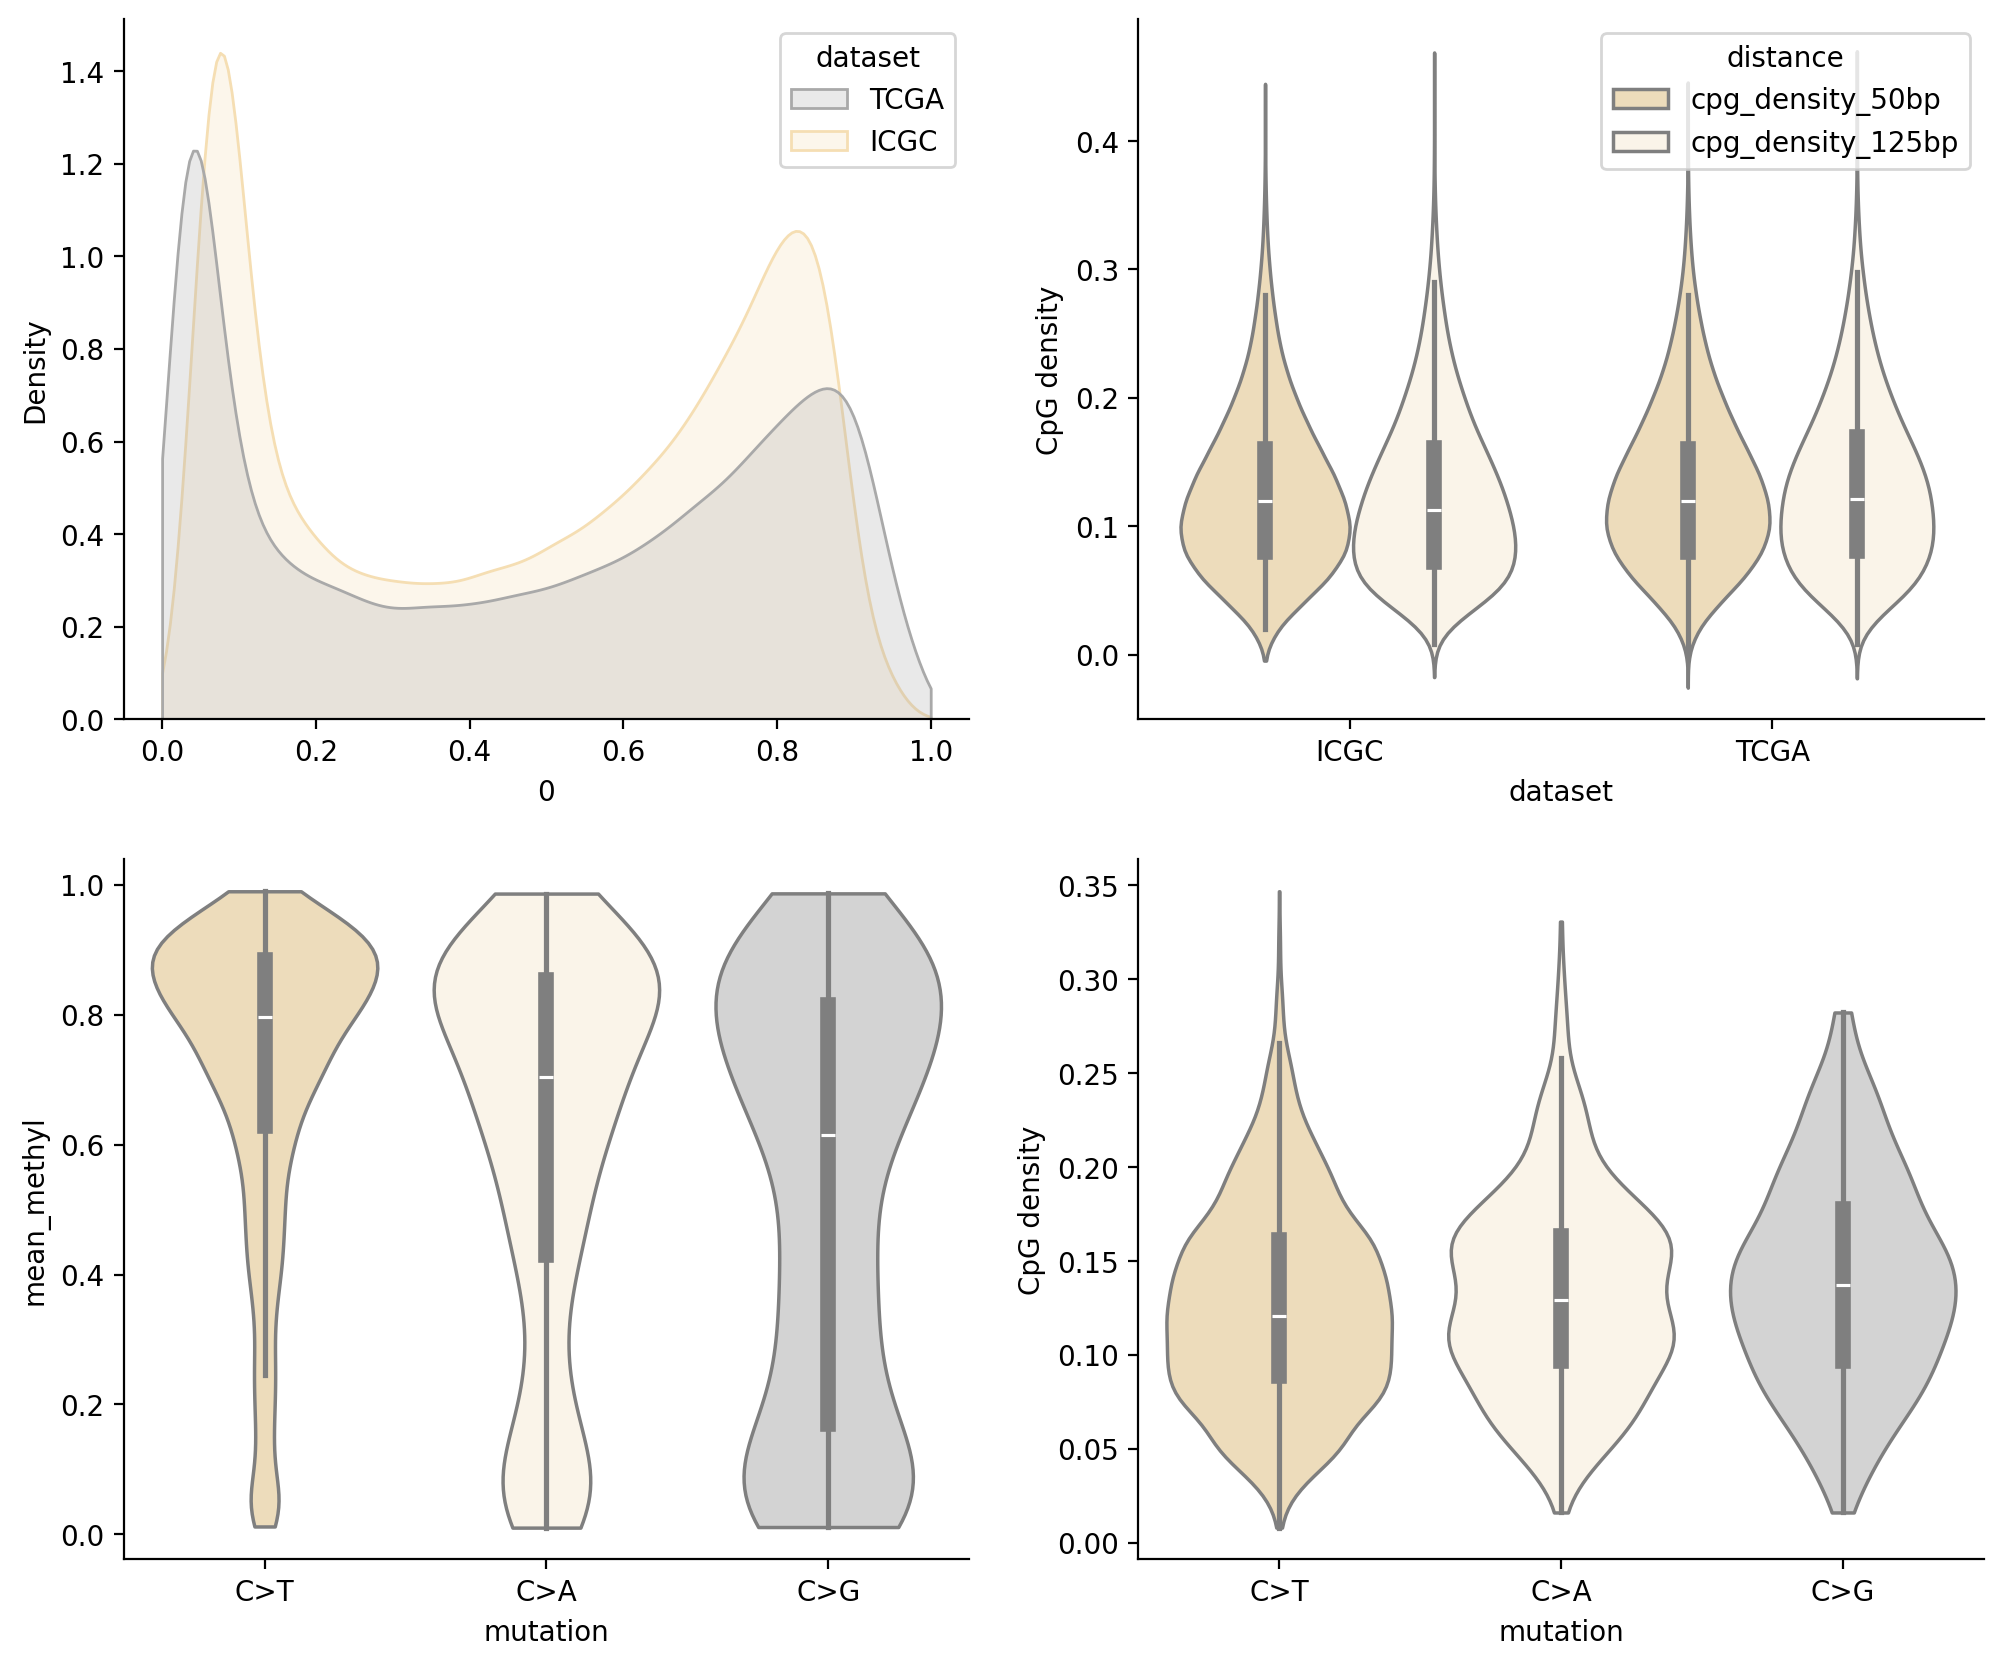

In [5]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes = axes.flatten()

# baseline TCGA methylation status
sns.kdeplot(mean_methyl_df, x = 0, hue = 'dataset', clip = [0, 1], fill = True, palette=['darkgrey', 'wheat'], ax = axes[0])

# cpg_density
sns.violinplot(density_df, hue = 'distance', y = 'CpG density', x = 'dataset', common_norm = True, ax = axes[1], bw_adjust = 2.5, palette = ['wheat', 'oldlace', 'lightgrey', 'white'])

# mutation frequency by methylation fraction and density
sns.violinplot(mut_in_measured_cpg_df.query("mutation != 'C>-' and distance == 'cpg_density_125bp'"), x = 'mutation', y = 'mean_methyl', ax = axes[2], palette = ['wheat', 'oldlace', 'lightgrey', 'white'], cut = 0, density_norm='count')
sns.violinplot(mut_in_measured_cpg_df.query("mutation != 'C>-' and distance == 'cpg_density_125bp'"), x = 'mutation', y = 'CpG density', ax = axes[3],  palette = ['wheat', 'oldlace', 'lightgrey', 'white'], cut = 0, density_norm='count')

sns.despine()

# save as svg
plt.savefig(os.path.join(fig_out_dir, 'supp_fig1a-d.svg'), format='svg', dpi = 300)

/tmp/ipykernel_336119/371044250.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = mut_in_measured_cpg_df, x = 'VAF_bin', y = 'methyl_fraction',  palette = 'Reds', density_norm = 'area', common_norm=True, cut = 0)


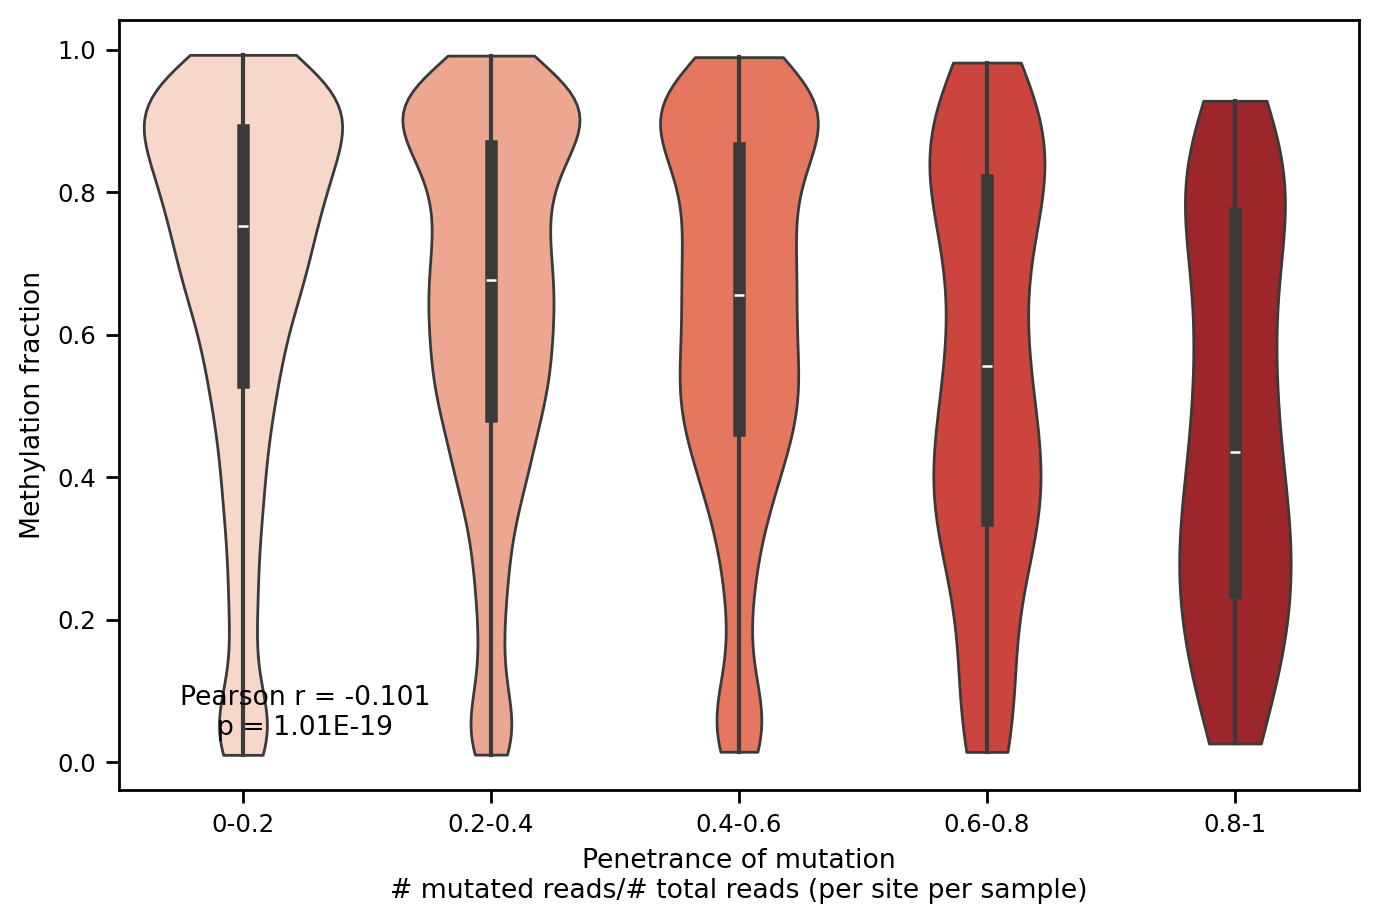

In [6]:
mut_in_measured_cpg_df = utils.join_df_with_illum_cpg(all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t)
mut_in_measured_cpg_df['methyl_fraction'] = utils.get_methyl_fractions(mut_in_measured_cpg_df, all_methyl_age_df_t)
mut_in_measured_cpg_df['avg_methyl_frac'] = all_methyl_age_df_t[mut_in_measured_cpg_df['#id']].mean().values
mut_in_measured_cpg_df['difference'] = mut_in_measured_cpg_df['methyl_fraction'] - mut_in_measured_cpg_df['avg_methyl_frac']

# bin mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'] into 5 equal width bins from 0 to 1
mut_in_measured_cpg_df['VAF_bin'] = pd.cut(
                mut_in_measured_cpg_df['DNA_VAF'],
                bins = 5,
                labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
                )

# new way
sns.set_context('paper')
# make bigger figure
plt.figure(figsize=(8,5), dpi=100)
sns.violinplot(data = mut_in_measured_cpg_df, x = 'VAF_bin', y = 'methyl_fraction',  palette = 'Reds', density_norm = 'area', common_norm=True, cut = 0)
plt.ylabel('Methylation fraction')
plt.xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
# add pearson correlation coefficient and pvalue to plot
p_val = pearsonr(mut_in_measured_cpg_df['DNA_VAF'], mut_in_measured_cpg_df['methyl_fraction']).pvalue
r = pearsonr(mut_in_measured_cpg_df['DNA_VAF'], mut_in_measured_cpg_df['methyl_fraction']).statistic

plt.text(
    0.15, 0.1, f'Pearson r = {round(r,3)}\np = {p_val:.2E}', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes
    )

plt.savefig(os.path.join(fig_out_dir, 'supp_fig1g.svg'), dpi = 300, format = 'svg')

# Supplementary Figure 2

In [7]:
icgc_dist_mean_metrics_w_annot_df = pd.read_parquet('../data/methylation_disturbance/icgc_dist_mean_metrics10kDist_w_annot_subset_vaf.parquet')
sample_to_dataset_map = icgc_mut_w_age_df.drop_duplicates(subset = ['case_submitter_id'])[['case_submitter_id', 'dataset']].set_index('case_submitter_id').to_dict()['dataset']
icgc_dist_mean_metrics_w_annot_df['dataset'] = icgc_dist_mean_metrics_w_annot_df['sample'].map(sample_to_dataset_map)
# remove PRAD because so few samples
icgc_dist_mean_metrics_w_annot_df = icgc_dist_mean_metrics_w_annot_df.query("dataset != 'PRAD'")

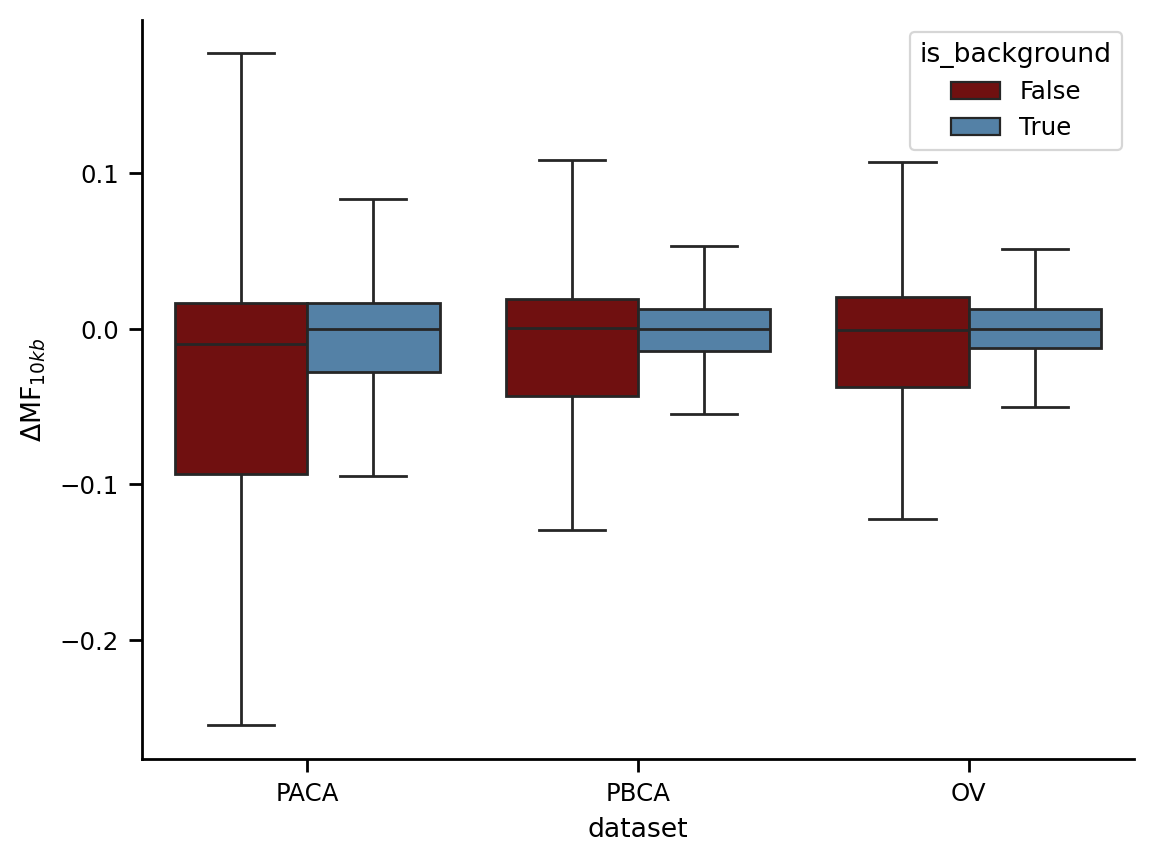

In [8]:
sns.boxplot(data = icgc_dist_mean_metrics_w_annot_df, x = 'dataset', y = 'median_dmf', hue = 'is_background', showfliers = False, palette = ['maroon', 'steelblue'])
# label y with delta MF using greek symbol
plt.ylabel(r'$\Delta$MF$_{10kb}$')
sns.despine()
plt.savefig(os.path.join(fig_out_dir, 'supp_fig2a.svg'), dpi = 300, format = 'svg')

/tmp/ipykernel_336119/4093257565.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


SignificanceResult(statistic=-0.08484301030868498, pvalue=0.0022013010030987492)
SignificanceResult(statistic=0.0950921018604122, pvalue=0.015299375734080559)
SignificanceResult(statistic=-0.1548547262457996, pvalue=7.358845184426803e-05)


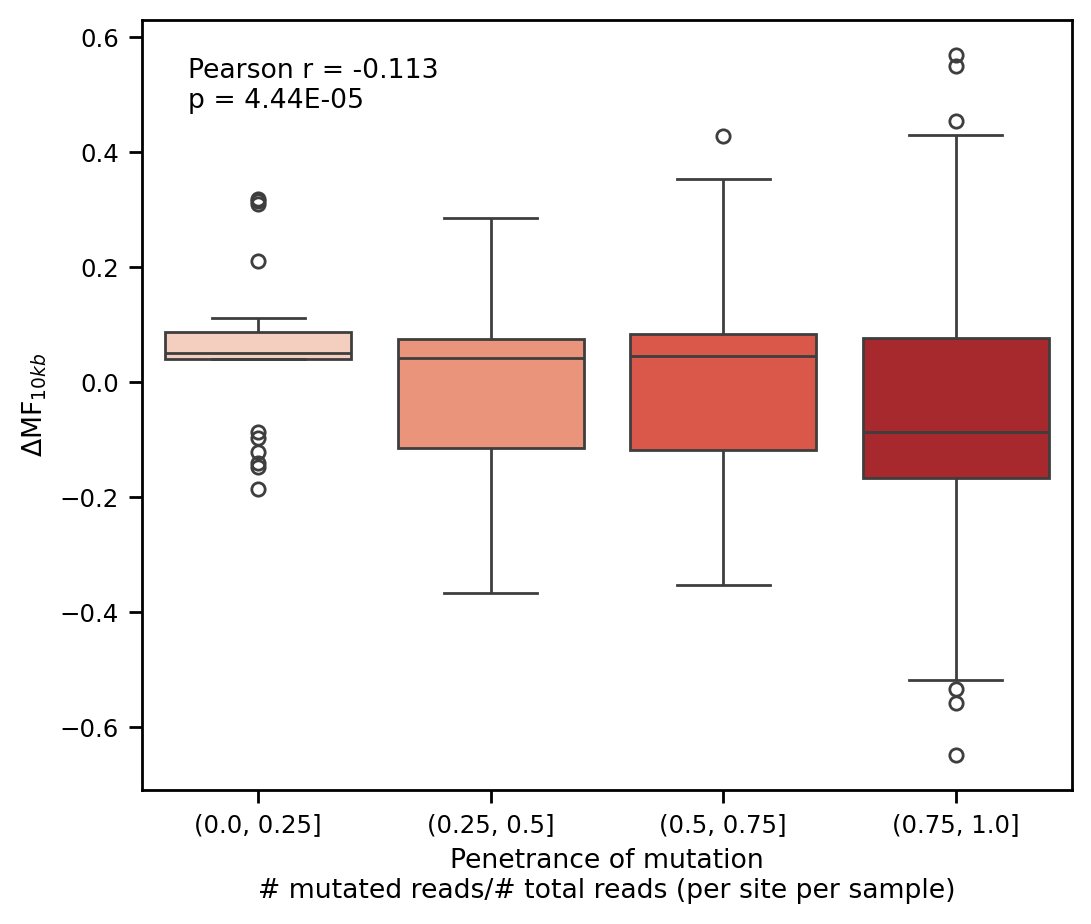

In [9]:
icgc_dist_mean_metrics_w_annot_all_vaf = pd.read_parquet('../data/methylation_disturbance/icgc_dist_mean_metrics10kDist_w_annot_all_vaf.parquet')
filtered_df = icgc_dist_mean_metrics_w_annot_all_vaf.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 650 events, which is  25%
num_top_muts = 650 # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
largest_eff_df = pd.concat([top_df, bottom_df])

fig, axes = plt.subplots(figsize = (6,5), dpi = 100)
sns.set_context('paper')

# bin by DNA VAF
largest_eff_df['DNA_VAF_bin'] = pd.cut(
    largest_eff_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )
# get absolute value of median dmf
largest_eff_df['abs_median_dmf'] = largest_eff_df['median_dmf'].abs()
# boxplot
sns.boxplot(
    data=largest_eff_df.query("is_background == False"),
    x='DNA_VAF_bin', y='median_dmf', showfliers=True, palette = 'Reds',
    ax = axes
    )
# corrs, median_abs_dmf is better than abs_median_dmf
print(spearmanr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_dmf']))
print(spearmanr(largest_eff_df.query("is_background == False and median_dmf >0")['DNA_VAF'], largest_eff_df.query("is_background == False and median_dmf >0")['median_dmf']))
print(spearmanr(largest_eff_df.query("is_background == False and median_dmf <=0")['DNA_VAF'], largest_eff_df.query("is_background == False and median_dmf <=0")['median_dmf']))


# add pearson r and pvalue to upper left corner)
r,p = pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_dmf'])
# add pearson r and pvalue to upper left corner
axes.text(
    0.05, 0.95, f'Pearson r = {round(r,3)}\np = {p:.2E}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
    )
axes.set_ylabel(r'$\Delta$MF$_{10kb}$')
axes.set_xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
# include 0 on y axis
#axes.set_ylim(bottom=0)
plt.savefig(os.path.join(fig_out_dir, 'supp_fig2g.svg'), dpi = 300, format = 'svg')

/tmp/ipykernel_336119/3563970085.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_dist_mean_metrics_w_annot_df_subset["z_score"] = (icgc_dist_mean_metrics_w_annot_df_subset["median_dmf"] - mean) / std_dev
/tmp/ipykernel_336119/3563970085.py:20: DtypeWarning: Columns (6,7,22,23,32,34,35,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df = pd.read_csv(mut_fn, sep="\t")


5_prime_UTR_variant
missense_variant
synonymous_variant
intergenic_region
intron_variant
3_prime_UTR_variant
exon_variant
upstream_gene_variant
downstream_gene_variant


/tmp/ipykernel_336119/3563970085.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 45, ha = 'right')
/tmp/ipykernel_336119/3563970085.py:125: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data = enrichments_posneg_df,
/tmp/ipykernel_336119/3563970085.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 45, ha = 'right')


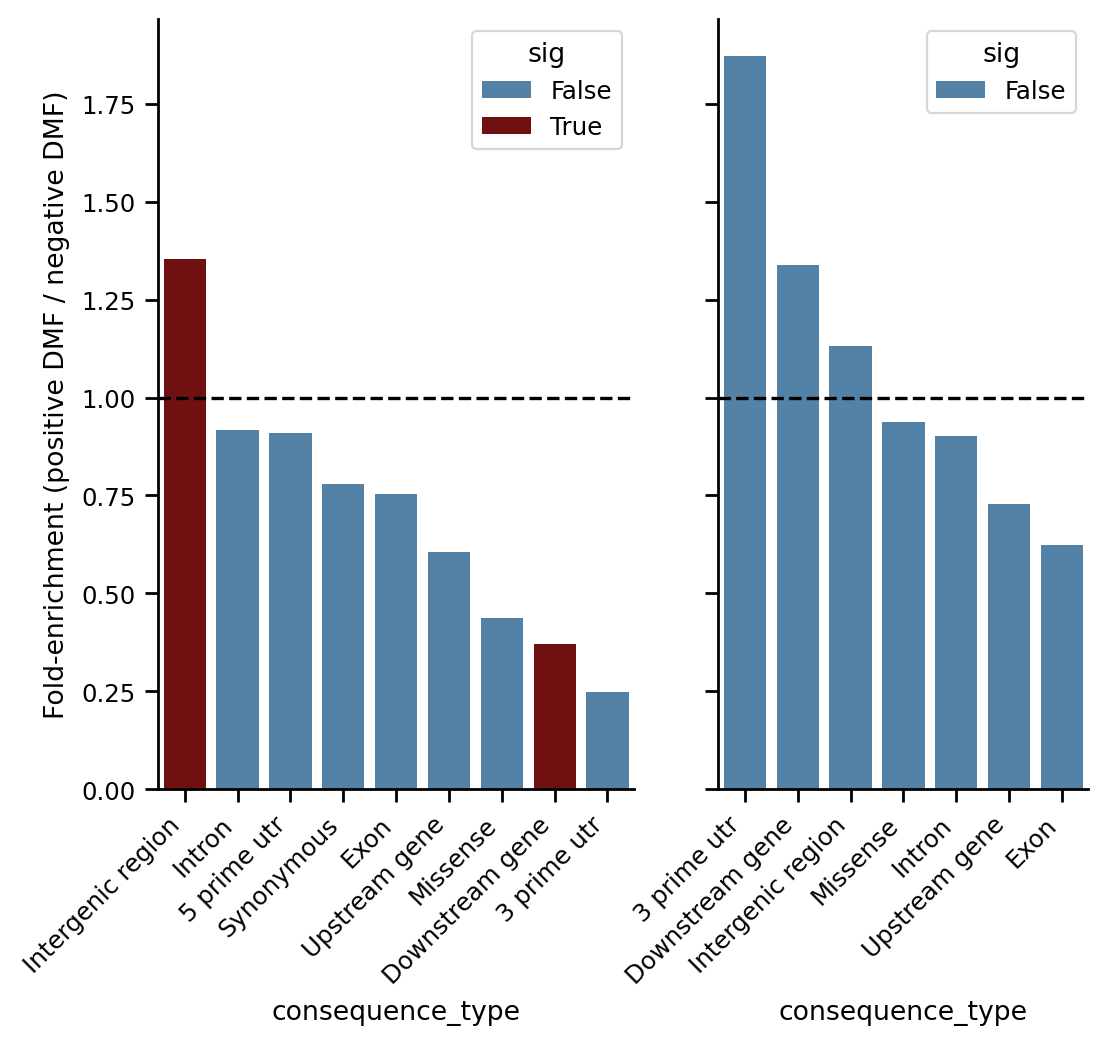

In [10]:
icgc_dist_mean_metrics_w_annot_df.drop_duplicates(subset=['mut_event'], inplace=True)

selected_mut_events = icgc_dist_mean_metrics_w_annot_df.query("mutated_sample == True and is_background == False and DNA_VAF >=.8")['mut_event'].unique()
icgc_dist_mean_metrics_w_annot_df_subset = icgc_dist_mean_metrics_w_annot_df.loc[
    (icgc_dist_mean_metrics_w_annot_df['index_event'].isin(selected_mut_events) | (icgc_dist_mean_metrics_w_annot_df['index_event'] == 'self') & (icgc_dist_mean_metrics_w_annot_df['is_background'] == False) & (icgc_dist_mean_metrics_w_annot_df['DNA_VAF'] >=.8))
]
icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

# get mean and std of background samples
mean = icgc_dist_mean_metrics_w_annot_df_subset.query("mutated_sample == True and is_background == True")["median_dmf"].mean()
std_dev = icgc_dist_mean_metrics_w_annot_df_subset.query("mutated_sample == True and is_background == True")["median_dmf"].std()
# for each non-background sample, calculate z-score
icgc_dist_mean_metrics_w_annot_df_subset["z_score"] = (icgc_dist_mean_metrics_w_annot_df_subset["median_dmf"] - mean) / std_dev

# read in icgc annotated mutations 
mut_fn = os.path.join("../data/icgc", "simple_somatic_mutation.open.tsv.gz")
mut_df = pd.read_csv(mut_fn, sep="\t")
# select relevant samples
relevant_samples = icgc_dist_mean_metrics_w_annot_df_subset['sample'].unique()
mut_df.query("icgc_donor_id in @relevant_samples", inplace=True)
# create mut event
mut_df['mut_event'] = mut_df['icgc_donor_id'] + "_" + mut_df['chromosome'] + ":" + mut_df['chromosome_start'].astype(str)
mut_df = mut_df[['mut_event', 'consequence_type', 'aa_mutation', 'gene_affected']]

# merge with icgc_dist_mean_metrics_w_annot_df_subset
icgc_dist_mean_metrics_w_annot_df_subset = icgc_dist_mean_metrics_w_annot_df_subset.merge(
    mut_df, on = 'mut_event', how = 'left'
)

icgc_dist_mean_metrics_w_annot_df_subset.drop_duplicates(subset=['mut_event'], inplace=True)

# check for enrichment of any consequence_type values in the z-score > 1.96 group verus the rest (only is_background == False)
(icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score.abs() >= 1.96")['consequence_type'].value_counts() / icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score.abs() >= 1.96")['consequence_type'].value_counts().sum()) / (icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score.abs() <= 1.96")['consequence_type'].value_counts() / icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score.abs() <= 1.96")['consequence_type'].value_counts().sum())

sig_events = icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score.abs() >= 1.96")['consequence_type'].value_counts().to_frame().reset_index().rename(columns = {'index': 'consequence_type', 'consequence_type': 'count'})
sig_events['prop'] = sig_events['count'] / sig_events['count'].sum()
nonsig_events = icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score.abs() <= 1.96")['consequence_type'].value_counts().to_frame().reset_index().rename(columns = {'index': 'consequence_type', 'consequence_type': 'count'})
nonsig_events['prop'] = nonsig_events['count'] / nonsig_events['count'].sum()


pos_sig_events = icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score >= 1")['consequence_type'].value_counts().to_frame().reset_index().rename(columns = {'index': 'consequence_type', 'consequence_type': 'count'})
pos_sig_events['prop'] = pos_sig_events['count'] / pos_sig_events['count'].sum()

neg_sig_events = icgc_dist_mean_metrics_w_annot_df_subset.query("is_background == False and z_score <= -1")['consequence_type'].value_counts().to_frame().reset_index().rename(columns = {'index': 'consequence_type', 'consequence_type': 'count'})
neg_sig_events['prop'] = neg_sig_events['count'] / neg_sig_events['count'].sum()

enrichments_sigNonsig = []
pvals_sigNonsig = [] 
enrichments_posNeg = []
pvals_posNeg = []
counts_sigNonsig = []
counts_posNeg = []
# test for significant enrichment
from scipy.stats import fisher_exact
shared_conseq = set(sig_events['consequence_type']).intersection(set(nonsig_events['consequence_type']))
for i in shared_conseq:
    print(i)
    enrichments_sigNonsig.append(sig_events.query("consequence_type == @i")['prop'].values[0] / nonsig_events.query("consequence_type == @i")['prop'].values[0])
    pvals_sigNonsig.append(stats.fisher_exact([[sig_events.query("consequence_type == @i")['count'].values[0], nonsig_events.query("consequence_type == @i")['count'].values[0]], [sig_events.query("consequence_type != @i")['count'].sum(), nonsig_events.query("consequence_type != @i")['count'].sum()]]).pvalue)
    counts_sigNonsig.append((sig_events.query("consequence_type == @i")['count'].values[0], nonsig_events.query("consequence_type == @i")['count'].values[0]))
    
enrichments_sigNonsig_df = pd.DataFrame({
    'consequence_type': list(shared_conseq),
    'enrichment_sigNonsig': enrichments_sigNonsig,
    'pval_sigNonsig': pvals_sigNonsig,
    'counts_sigNonsig': counts_sigNonsig,
})
    
shared_conseq = set(pos_sig_events['consequence_type']).intersection(set(neg_sig_events['consequence_type'])) 
for i in shared_conseq:
    enrichments_posNeg.append(pos_sig_events.query("consequence_type == @i")['prop'].values[0] / neg_sig_events.query("consequence_type == @i")['prop'].values[0])
    pvals_posNeg.append(stats.fisher_exact([[pos_sig_events.query("consequence_type == @i")['count'].values[0], neg_sig_events.query("consequence_type == @i")['count'].values[0]], [pos_sig_events.query("consequence_type != @i")['count'].sum(), neg_sig_events.query("consequence_type != @i")['count'].sum()]]).pvalue)
    counts_posNeg.append((pos_sig_events.query("consequence_type == @i")['count'].values[0], neg_sig_events.query("consequence_type == @i")['count'].values[0]))
    
# turn into df
enrichments_posneg_df = pd.DataFrame({
    'consequence_type': list(shared_conseq),
    'enrichment_posNeg': enrichments_posNeg,
    'pval_posNeg': pvals_posNeg,
    'counts_posNeg': counts_posNeg,
    
})

# binarize pvalues
enrichments_sigNonsig_df['sig'] = enrichments_sigNonsig_df['pval_sigNonsig'].apply(lambda x: x < .05)
enrichments_posneg_df['sig'] = enrichments_posneg_df['pval_posNeg'].apply(lambda x: x < .05)

# split count columns into 2
enrichments_sigNonsig_df['sig_counts'] = enrichments_sigNonsig_df['counts_sigNonsig'].apply(lambda x: x[0])
enrichments_sigNonsig_df['nonsig_counts'] = enrichments_sigNonsig_df['counts_sigNonsig'].apply(lambda x: x[1])
# split count columns into 2
enrichments_posneg_df['pos_counts'] = enrichments_posneg_df['counts_posNeg'].apply(lambda x: x[0])
enrichments_posneg_df['neg_counts'] = enrichments_posneg_df['counts_posNeg'].apply(lambda x: x[1])

enrichments_posneg_df['total_counts'] = enrichments_posneg_df['pos_counts'] + enrichments_posneg_df['neg_counts']
enrichments_sigNonsig_df['total_counts'] = enrichments_sigNonsig_df['sig_counts'] + enrichments_sigNonsig_df['nonsig_counts']

# rename consequence types
enrichments_sigNonsig_df['consequence_type'] = enrichments_sigNonsig_df['consequence_type'].apply(lambda x: x.replace('_variant', ''))
enrichments_sigNonsig_df['consequence_type'] = enrichments_sigNonsig_df['consequence_type'].apply(lambda x: x.replace('_', ' '))
enrichments_sigNonsig_df['consequence_type'] = enrichments_sigNonsig_df['consequence_type'].apply(lambda x: x.capitalize())

enrichments_posneg_df['consequence_type'] = enrichments_posneg_df['consequence_type'].apply(lambda x: x.replace('_variant', ''))
enrichments_posneg_df['consequence_type'] = enrichments_posneg_df['consequence_type'].apply(lambda x: x.replace('_', ' '))
enrichments_posneg_df['consequence_type'] = enrichments_posneg_df['consequence_type'].apply(lambda x: x.capitalize())

# plot as barplot
# make second plot smaller 
fig, axes = plt.subplots(1, 2, figsize = (6, 5), sharey = True, gridspec_kw={'width_ratios': [9, 7]})
# set order based on enrichment_sigNonsig 
orderr = enrichments_sigNonsig_df.sort_values('enrichment_sigNonsig', ascending = False)['consequence_type']
sns.barplot(data = enrichments_sigNonsig_df.query("total_counts >=5"),
            x = 'consequence_type', y = 'enrichment_sigNonsig', hue = 'sig', ax = axes[0], palette = [ 'steelblue','maroon'], order = orderr
            )
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 45, ha = 'right')
# draw a line at 1
axes[0].axhline(1, color = 'black', linestyle = '--')
axes[0].set_ylabel('Fold-enrichment (sig / nonsig)')
sns.despine()
# set order based on enrichment_posNeg
orderr = enrichments_posneg_df.sort_values('enrichment_posNeg', ascending = False)['consequence_type']
sns.barplot(data = enrichments_posneg_df,
            x = 'consequence_type', y = 'enrichment_posNeg', hue = 'sig', ax = axes[1], palette = [ 'steelblue','maroon'], order = orderr
            )
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 45, ha = 'right')
# draw a line at 1
axes[1].axhline(1, color = 'black', linestyle = '--')
axes[0].set_ylabel('Fold-enrichment (positive DMF / negative DMF)')

sns.despine()

# save as svg
plt.savefig(os.path.join(fig_out_dir, 'supp_fig2e-f.svg'), dpi = 300, bbox_inches = 'tight', format = 'svg')

# Supplementary Figure 3

In [47]:
tcga_dist_mean_metrics_w_annot_df = pd.read_parquet('../data/methylation_disturbance/normal_tissue_dist_mean_metrics_1mb.parquet')

selected_mut_events = tcga_dist_mean_metrics_w_annot_df.query(
    "mutated_sample == True and is_background == False and DNA_VAF >=.1"
    )['mut_event'].unique()
tcga_norm_dist_mean_metrics_df_subset = tcga_dist_mean_metrics_w_annot_df.loc[
    (tcga_dist_mean_metrics_w_annot_df['index_event'].isin(selected_mut_events) | (tcga_dist_mean_metrics_w_annot_df['index_event'] == 'self') & (tcga_dist_mean_metrics_w_annot_df['is_background'] == False) & (tcga_dist_mean_metrics_w_annot_df['DNA_VAF'] >=.1))
].copy(deep = True)

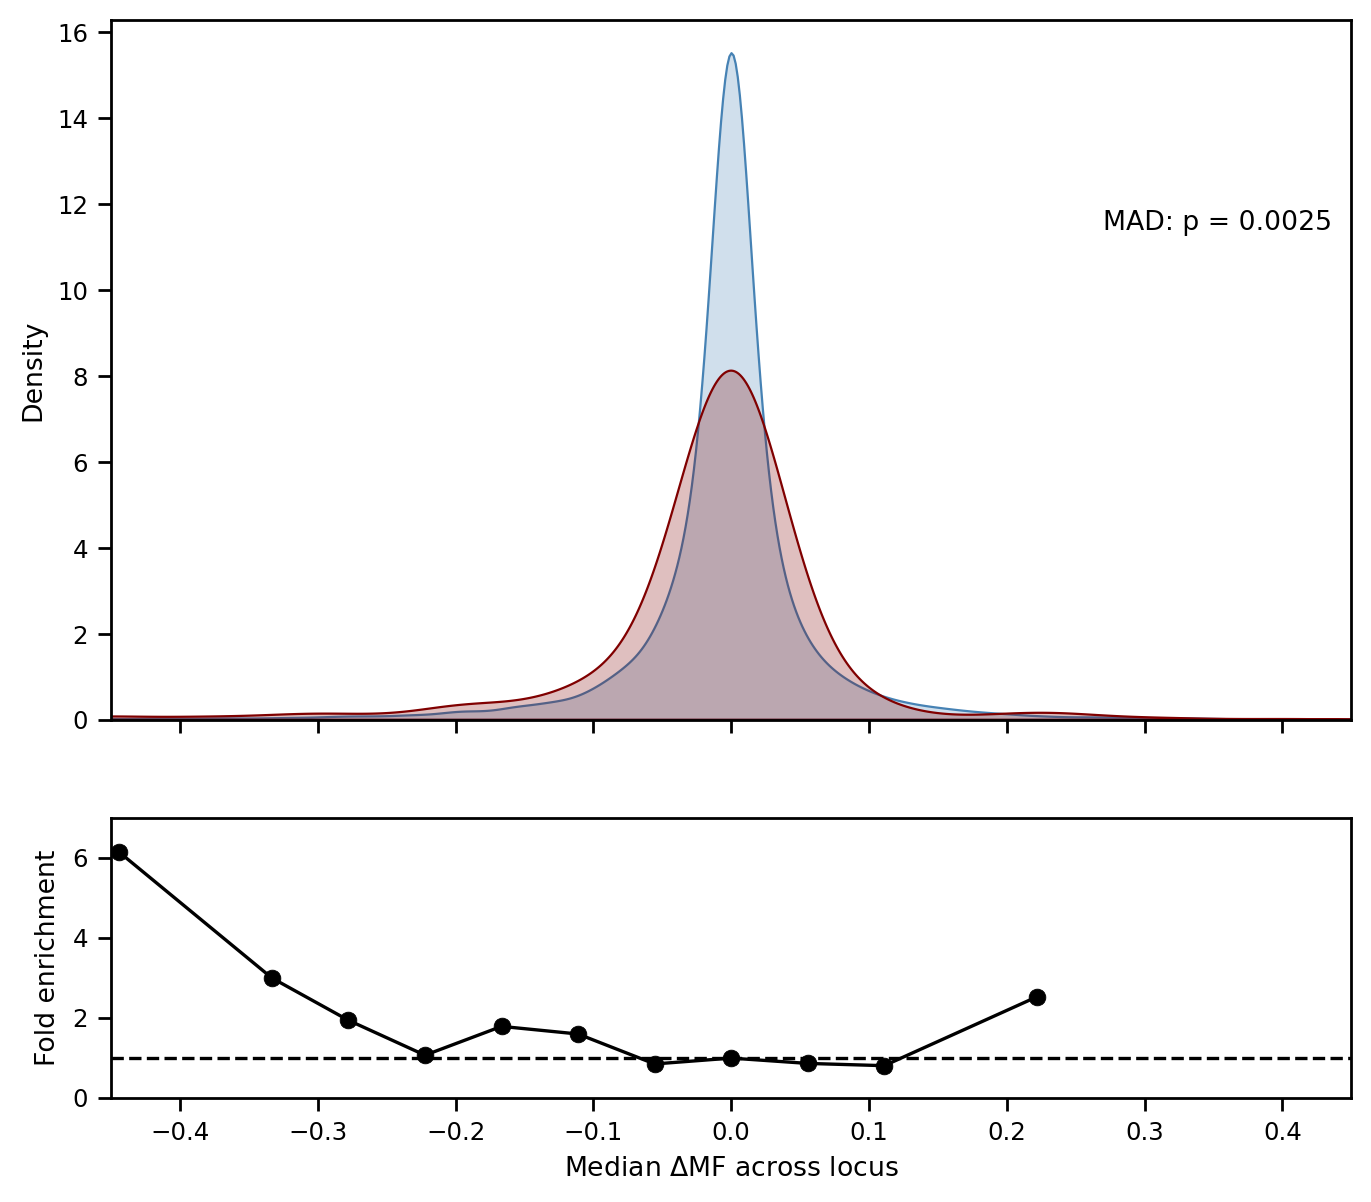

In [48]:
# create an analyaze comethylatino object
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    tcga_dist_mean_metrics_w_annot_df.query("distance == 1 and mutated_sample == True and (DNA_VAF <= .15 or is_background == True)"),
    metric = 'median_dmf',
    axes = axes,
    consortium = 'ICGC',
    out_fn = ""
    )
# test for significant difference
from scipy.stats import mannwhitneyu,ttest_ind, kstest
group1 = tcga_dist_mean_metrics_w_annot_df.query("distance == 1 and is_background == False and mutated_sample == True and DNA_VAF <= .15")['median_abs_dmf']
group2 = tcga_dist_mean_metrics_w_annot_df.query("distance == 1 and is_background == True and mutated_sample == True")['median_abs_dmf']
result = ttest_ind(group1, group2, alternative = 'two-sided')
# add pvalue to plot
axes[0].text(0.8, 0.7, f"MAD: p = {result.pvalue:.2}", transform=axes[0].transAxes)
axes[1].set_ylim(0, 7)

plt.savefig(os.path.join(fig_out_dir, 'supp_fig3a.svg'), dpi = 300, bbox_inches = 'tight', format = 'svg')

10000
Ttest_indResult(statistic=1.7709275302617533, pvalue=0.07657756538115884)
1
Ttest_indResult(statistic=2.911950096110956, pvalue=0.0035931974960286576)
10
Ttest_indResult(statistic=2.897106247909468, pvalue=0.0037676580377493185)
100
Ttest_indResult(statistic=2.2944024494742936, pvalue=0.021770971181507927)
1000
Ttest_indResult(statistic=1.9855121798034878, pvalue=0.04709209200158742)
50000
Ttest_indResult(statistic=-1.312390489871276, pvalue=0.18939311562657857)


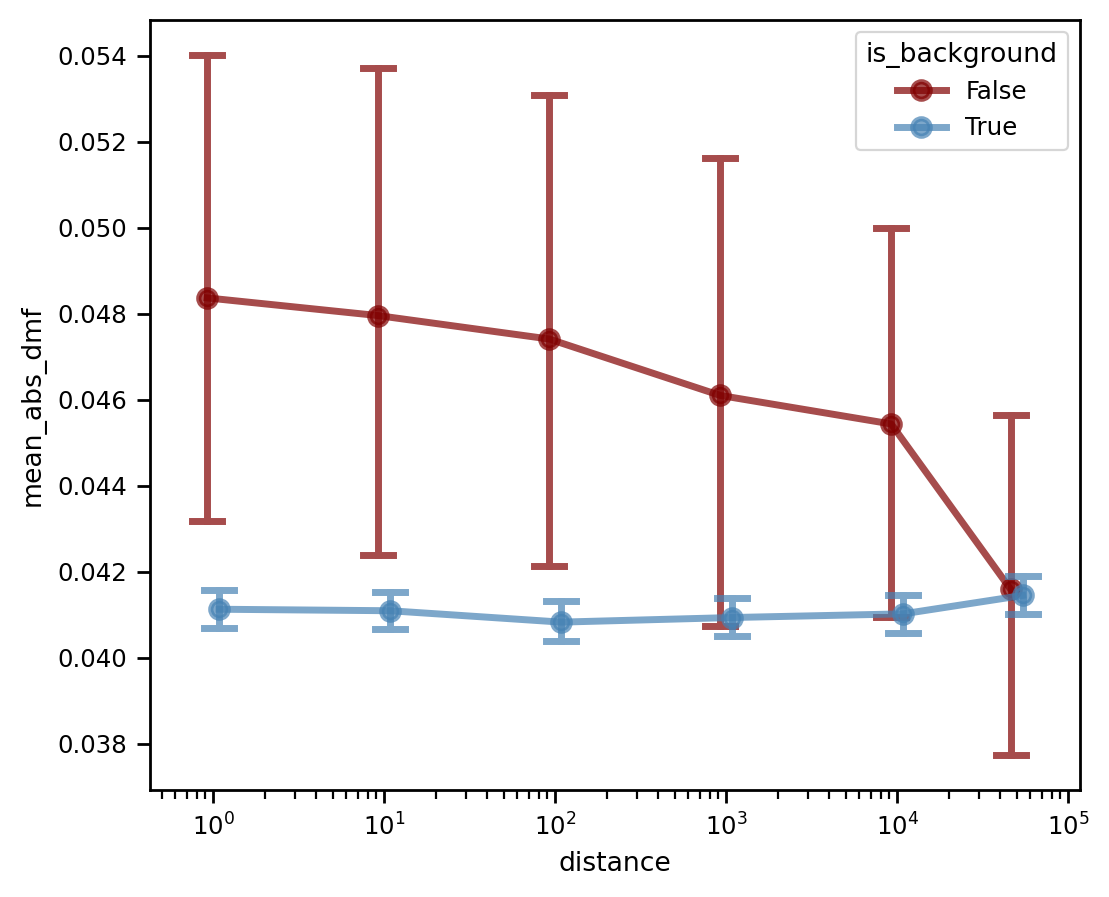

In [13]:
# 1000 bp 
fig, axes = plt.subplots(1, 1, figsize = (6, 5))
# convert to log scale
ignore_dists = [980000, 500000, 100000, 5000]

sns.pointplot(
    tcga_dist_mean_metrics_w_annot_df.query("(DNA_VAF <= .15 or is_background == True) and distance not in @ignore_dists"),
    x = 'distance', hue = 'is_background', y = 'mean_abs_dmf', ax = axes,
    native_scale=True, palette=['maroon', 'steelblue'], dodge=.1,
    capsize = .25, alpha=.7, log_scale=(True, False), linewidth = 2.5,
    estimator=np.mean, errorbar = 'ci',
)
for distance in tcga_dist_mean_metrics_w_annot_df['distance'].unique():
    if distance in ignore_dists:
        continue
    print(distance)
    # get the two groups
    group1 = tcga_dist_mean_metrics_w_annot_df.query("distance == @distance and is_background == False and DNA_VAF <= .1")['median_abs_dmf']
    group2 = tcga_dist_mean_metrics_w_annot_df.query("distance == @distance and is_background == True")['median_abs_dmf']
    from scipy.stats import ttest_ind
    print(ttest_ind(group1, group2))
    
plt.savefig(os.path.join(fig_out_dir, 'supp_fig3c.svg'), dpi = 300, bbox_inches = 'tight', format = 'svg')

# Supplementary Figure 4

In [14]:
my_palette= ['darkgrey', 'steelblue', 'maroon', 'darkgoldenrod', 'lightgrey', 'lightblue', 'salmon', 'wheat']
dsets = ['LGG', 'THCA', 'GBM', 'SARC', 'KIRP']
dsets_w_norm = ['KIRP', 'THCA', 'LIHC', 'COAD']

def read_in_trained_clock_perf(out_dir:str, separate:bool=False):
    
    model_dict = {}
    feat_dict = {}
    fmap_paths = {}
    predictions_df = {}
    parameters_dict = {}
    
    for file in glob.glob(out_dir + "/*.pkl"):
        with open(file, 'rb'):
            model_dict[int(file.split("_")[-1].split(".")[0])] = pd.read_pickle(file)
    # read each features parquet file into dictionary and create fmap
    for file in glob.glob(out_dir + "/*features.parquet"):
        cv_num = int(file.split("_")[-2])
        feat_dict[cv_num] = pd.read_parquet(file)
        # write to fmap
        fmap_df = feat_dict[cv_num].reset_index()
        fmap_df['feat_type'] = 'q' # i for indicator, q for quantity
        fmap_df.to_csv(os.path.join(out_dir, "fmap_" + str(cv_num) + ".txt"), sep = '\t', header=False, index=False)
        fmap_paths[cv_num] = os.path.join(out_dir, "fmap_" + str(cv_num) + ".txt")
    # read in the predictions df
    predictions_fn = glob.glob(out_dir + "/*clock_predictions.parquet")
    predictions_df = pd.read_parquet(predictions_fn[0])
    
    with open(os.path.join(out_dir, "parameters.json"), 'r') as f:
        parameters = json.load(f)
    parameters_dict[out_dir] = parameters
        
    return model_dict, feat_dict, fmap_paths, predictions_df, parameters
    
    
def make_plots(mut_df, mut_and_methyl_df, is_combined = False, corr_method = 'pearson'):
    # make middle subplot half size of others
    fig, axes = plt.subplots(1,3, figsize=(16,5), gridspec_kw={'width_ratios': [1, .3, 1]})
    # lm plot of normal tissue age vs. mut age
    if is_combined:
        #sns.regplot(mut_df, x = 'age_at_index', y='mut_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'}, ax = axes[0])
        sns.histplot(x = 'age_at_index', y='mut_age',  data = mut_df, ax = axes[0], bins = 50, pthresh = 0.1, cmap = 'coolwarm', cbar = True, cbar_kws = {'label': 'Density'}, rasterized = True)
        if corr_method == 'pearson':
            r, p = pearsonr(mut_df.query("tissue_type == 'normal'")['age_at_index'], mut_df.query("tissue_type == 'normal'")['mut_age'])
            axes[0].text(0.05, 0.85, f"normal r = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
            r, p = pearsonr(mut_df.query("tissue_type == 'cancer'")['age_at_index'], mut_df.query("tissue_type == 'cancer'")['mut_age'])
            axes[0].text(0.05, 0.75, f"cancer r = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
        else:
            r, p = spearmanr(mut_df.query("tissue_type == 'normal'")['age_at_index'], mut_df.query("tissue_type == 'normal'")['mut_age'])
            axes[0].text(0.05, 0.85, f"normal Spearman = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
            r, p = spearmanr(mut_df.query("tissue_type == 'cancer'")['age_at_index'], mut_df.query("tissue_type == 'cancer'")['mut_age'])
            axes[0].text(0.05, 0.75, f"cancer Spearman = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)

        # correlation within each tissue
        corr_df = mut_df.groupby(['dataset','tissue_type'])[['age_at_index', 'mut_age']].corr(method = corr_method).iloc[::2,-1].sort_values().to_frame().pivot_table(index='dataset', columns='tissue_type', values='mut_age').dropna().sort_values('normal')
        print(corr_df.mean())
        sns.heatmap(corr_df, annot=True,cmap = 'coolwarm',vmin=-1, vmax=1, ax = axes[1])
        
        # residual associations w methylationn
        # calculate mutation residuals
        # using all mutation
        mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_df).fit()
        # using mutation samples w methyl
        #mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
        # calculate residuals
        methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

        # add scatterplot
        #sns.regplot(x = 'mut_age_resid', y='methyl_age_resid',  data = mut_and_methyl_df, ax = axes[2], scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'})
        sns.histplot(x = 'mut_age_resid', y='methyl_age_resid',  data = mut_and_methyl_df, ax = axes[2], bins = 50, pthresh = 0.1, cmap = 'coolwarm', cbar = True, cbar_kws = {'label': 'Density'}, rasterized = True)
        if corr_method == 'pearson':
            r, p = pearsonr(mut_and_methyl_df.query("tissue_type == 'normal'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'normal'")['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"normal r = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
            r, p = pearsonr(mut_and_methyl_df.query("tissue_type == 'cancer'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'cancer'")['methyl_age_resid'])
            axes[2].text(0.05, 0.75, f"cancer r = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
        else:
            r, p = spearmanr(mut_and_methyl_df.query("tissue_type == 'normal'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'normal'")['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"normal Spearman = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
            r, p = spearmanr(mut_and_methyl_df.query("tissue_type == 'cancer'")['mut_age_resid'], mut_and_methyl_df.query("tissue_type == 'cancer'")['methyl_age_resid'])
            axes[2].text(0.05, 0.75, f"cancer Spearman = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
    else:
        sns.regplot(mut_df, x = 'age_at_index', y='mut_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'}, ax = axes[0])
        if corr_method == 'pearson':
            r, p = pearsonr(mut_df['age_at_index'], mut_df['mut_age'])
            axes[0].text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=axes[0].transAxes)
        else: 
            r, p = spearmanr(mut_df['age_at_index'], mut_df['mut_age'])
            axes[0].text(0.05, 0.85, f"Spearman = {r:.2f}\np = {p:.2e}",transform=axes[0].transAxes)

        # correlation within each tissue
        corr_df = mut_df.groupby('dataset')[['age_at_index', 'mut_age']].corr(method = corr_method).iloc[::2,-1].sort_values().to_frame()
        # drop second level of index
        corr_df.index = corr_df.index.droplevel(1)
        sns.heatmap(corr_df, annot=True,cmap = 'coolwarm',vmin=-1, vmax=1, ax = axes[1])
        print(corr_df.mean())
        # residual associations w methylationn
        # calculate mutation residuals
        # using all mutation
        mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_df).fit()
        # using mutation samples w methyl
        #mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
        # calculate residuals
        methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
        mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

        # add scatterplot
        sns.regplot(x = 'mut_age_resid', y='methyl_age_resid', data = mut_and_methyl_df, ax = axes[2], scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True},line_kws={'color':'black'})
        if corr_method == 'pearson':
            r, p = pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)
        else: 
            r, p = spearmanr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
            axes[2].text(0.05, 0.85, f"Spearman = {r:.2f}\np = {p:.2e}", transform=axes[2].transAxes)

    sns.despine()
    
# combined mut and methyl
combined_mut_model_dict, combined_mut_feat_dict, combined_mut_fmap_paths, combined_mut_predictions_df, combined_mut_parameters = read_in_trained_clock_perf("../data/models_and_predictions/mut/all_features")
combined_methyl_model_dict, combined_methyl_feat_dict, combined_methyl_fmap_paths, combined_methyl_predictions_df, combined_methyl_parameters = read_in_trained_clock_perf("../data/models_and_predictions/methyl/all_features")
# combine predictions
combined_predictions_df = pd.concat([combined_methyl_predictions_df, combined_mut_predictions_df], axis = 1)
combined_predictions_df.dropna(inplace = True)
# drop duplicate columns
combined_predictions_df = combined_predictions_df.loc[:, ~combined_predictions_df.columns.duplicated()]
combined_mut_predictions_df['tissue_type'] = combined_mut_predictions_df.index.str.split('_').str[1]
combined_predictions_df['tissue_type'] = combined_predictions_df.index.str.split('_').str[1]

# read in normal mut and methyl
normal_mut_model_dict, normal_mut_feat_dict, normal_mut_fmap_paths, normal_mut_predictions_df, normal_mut_parameters = read_in_trained_clock_perf("../data/models_and_predictions/normal_tissue/mut/all_features")
normal_methyl_model_dict, normal_methyl_feat_dict, normal_methyl_fmap_paths, normal_methyl_predictions_df, normal_methyl_parameters = read_in_trained_clock_perf("../data/models_and_predictions/normal_tissue/methyl/all_features")
# combine predictions
normal_predictions_df = pd.concat([normal_methyl_predictions_df, normal_mut_predictions_df], axis = 1)
normal_predictions_df.dropna(inplace = True)
# drop duplicate columns
normal_predictions_df = normal_predictions_df.loc[:, ~normal_predictions_df.columns.duplicated()]

/tmp/ipykernel_336119/3878429800.py:19: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.barplot(
/tmp/ipykernel_336119/3878429800.py:19: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
/tmp/ipykernel_336119/3878429800.py:19: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


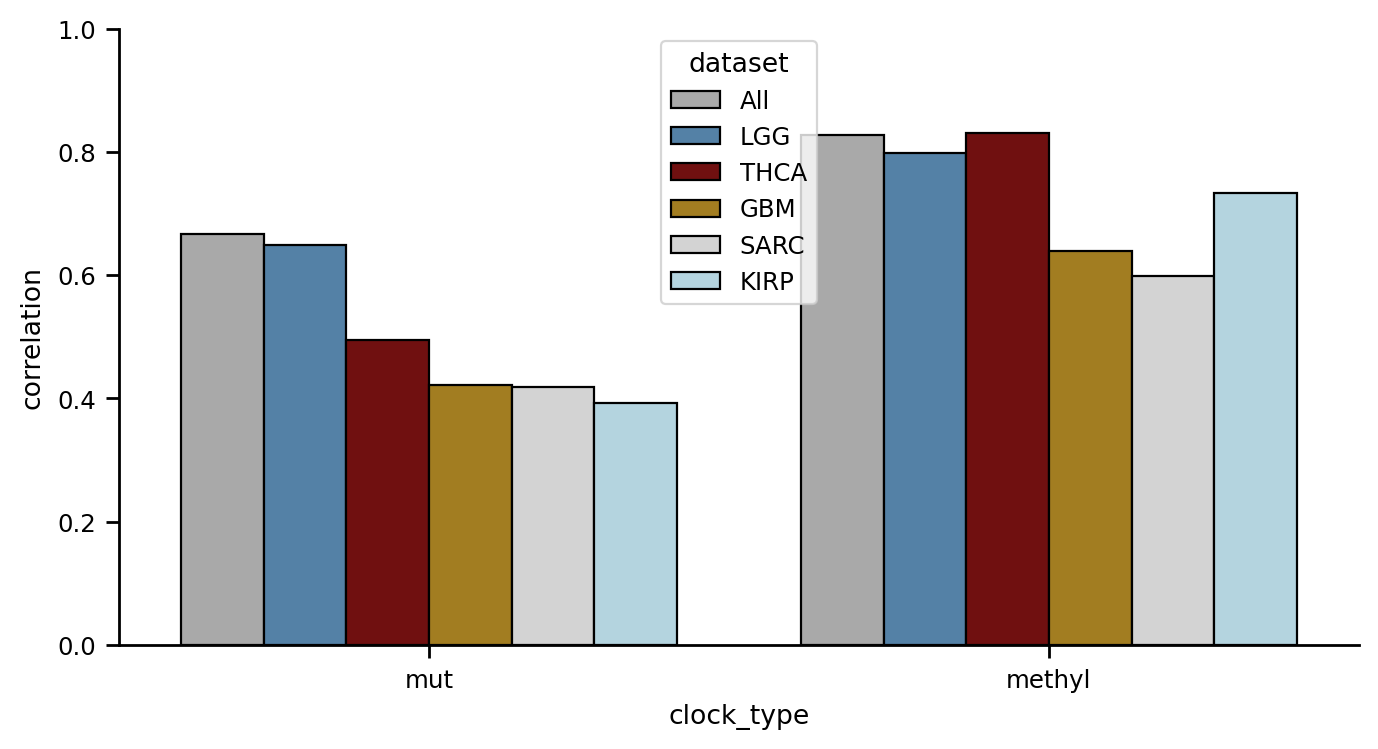

In [15]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

mut_and_methyl_df = combined_predictions_df.query("dataset in @dsets and tissue_type == 'cancer'")

# get the correlation values in each cv
mut_across_tissues_corr = mut_and_methyl_df[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
mut_across_tissues_corr['dataset'] = 'All'
methyl_across_tissues_corr = mut_and_methyl_df[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()
methyl_across_tissues_corr['dataset'] = 'All'
# get the correlation values in each dataset in each cv
mut_within_tissues_corr = mut_and_methyl_df.groupby(['dataset'])[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
methyl_within_tissues_corr = mut_and_methyl_df.groupby(['dataset'])[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()

# combine
all_corrs = pd.DataFrame({'dataset' : np.concatenate([mut_across_tissues_corr['dataset'], methyl_across_tissues_corr['dataset'], mut_within_tissues_corr['dataset'], methyl_within_tissues_corr['dataset']]), 'correlation': np.concatenate([mut_across_tissues_corr['mut_age'], methyl_across_tissues_corr['methyl_age'], mut_within_tissues_corr['mut_age'], methyl_within_tissues_corr['methyl_age']]), 'clock_type': np.concatenate([['mut']*len(mut_across_tissues_corr), ['methyl']*len(methyl_across_tissues_corr), ['mut']*len(mut_within_tissues_corr), ['methyl']*len(methyl_within_tissues_corr)])})

# set hue order based on mean with each clock_type group[]
hue_order = all_corrs.groupby(['dataset'])['correlation'].mean().sort_values(ascending=False).index
sns.barplot(
    all_corrs, hue = 'dataset', y = 'correlation', x = 'clock_type',
    palette = my_palette, hue_order = ['All', 'LGG','THCA','GBM','SARC','KIRP' ], errorbar = 'se',
    estimator=np.mean, 
    errwidth=1.5, capsize=0.05, 
    edgecolor = 'black', errcolor='black', ax = axes
    )
sns.despine()
# save to svg
plt.ylim(0,1)
plt.savefig(os.path.join(fig_out_dir, "supp_fig4a.svg"), format = 'svg')

/tmp/ipykernel_336119/2947590732.py:20: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
/tmp/ipykernel_336119/2947590732.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


KIRP
PearsonRResult(statistic=0.824368980187161, pvalue=0.04356060305863675)
PearsonRResult(statistic=0.3896816554928846, pvalue=0.44506444573103043)
THCA
PearsonRResult(statistic=0.9543599210412042, pvalue=9.800492918852517e-09)
PearsonRResult(statistic=0.3890280222341147, pvalue=0.1364112218090384)
LIHC
PearsonRResult(statistic=0.8184606239598637, pvalue=0.02439396345303435)
PearsonRResult(statistic=0.4421040031953602, pvalue=0.32060598812313346)
COAD
PearsonRResult(statistic=0.5087166511569647, pvalue=0.11004243718546154)
PearsonRResult(statistic=0.24224021800753234, pvalue=0.47296086824572153)
all
PearsonRResult(statistic=0.923863947344558, pvalue=1.95554651823037e-17)
PearsonRResult(statistic=0.7431312500629976, pvalue=3.976449900516374e-08)


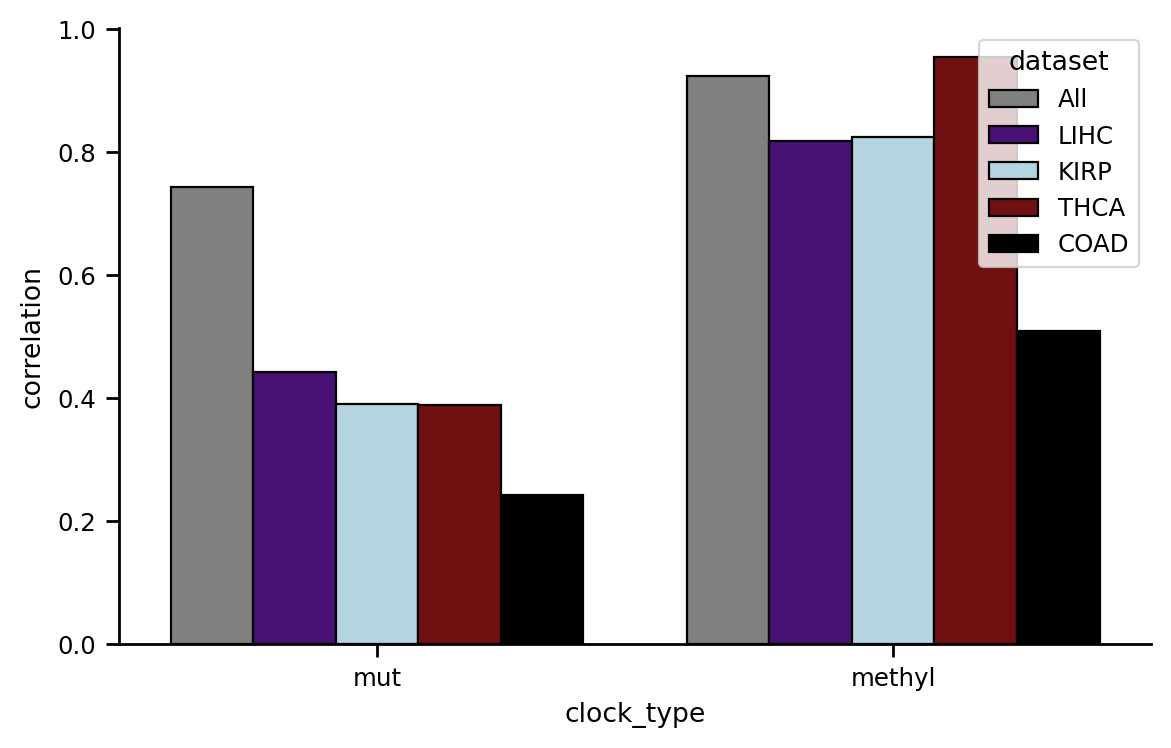

In [16]:
fig, axes = plt.subplots(1,1, figsize=(6.66,4))

mut_df = normal_predictions_df.query("dataset in @dsets_w_norm")
mut_and_methyl_df = normal_predictions_df.query("dataset in @dsets_w_norm")

# get the correlation values in each cv
mut_across_tissues_corr = mut_df[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
mut_across_tissues_corr['dataset'] = 'All'
methyl_across_tissues_corr = mut_and_methyl_df[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()
methyl_across_tissues_corr['dataset'] = 'All'
# get the correlation values in each dataset in each cv
mut_within_tissues_corr = mut_df.groupby(['dataset'])[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
methyl_within_tissues_corr = mut_and_methyl_df.groupby(['dataset'])[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()

# combine
all_corrs = pd.DataFrame({'dataset' : np.concatenate([mut_across_tissues_corr['dataset'], methyl_across_tissues_corr['dataset'], mut_within_tissues_corr['dataset'], methyl_within_tissues_corr['dataset']]), 'correlation': np.concatenate([mut_across_tissues_corr['mut_age'], methyl_across_tissues_corr['methyl_age'], mut_within_tissues_corr['mut_age'], methyl_within_tissues_corr['methyl_age']]), 'clock_type': np.concatenate([['mut']*len(mut_across_tissues_corr), ['methyl']*len(methyl_across_tissues_corr), ['mut']*len(mut_within_tissues_corr), ['methyl']*len(methyl_within_tissues_corr)])})

# set hue order based on mean with each clock_type group[]
hue_order = all_corrs.query("clock_type == 'mut'").groupby(['dataset'])['correlation'].mean().sort_values(ascending=False).index
sns.barplot(
    all_corrs, hue = 'dataset', y = 'correlation', x = 'clock_type',
    palette = ['grey','indigo', 'lightblue', 'maroon', 'black'], hue_order = hue_order, errorbar = 'se',
    estimator=np.median, 
    errwidth=1.5, capsize=0.05, 
    edgecolor = 'black', errcolor='black', ax = axes
    )
sns.despine()

# print pearsonr for each dataset
for dset in dsets_w_norm:
    print(dset)
    print(pearsonr(mut_and_methyl_df.query("dataset == @dset")['age_at_index'], mut_and_methyl_df.query("dataset == @dset")['methyl_age']))
    print(pearsonr(mut_and_methyl_df.query("dataset == @dset")['age_at_index'], mut_and_methyl_df.query("dataset == @dset")['mut_age']))
print('all')
print(pearsonr(mut_and_methyl_df['age_at_index'], mut_and_methyl_df['methyl_age']))
print(pearsonr(mut_and_methyl_df['age_at_index'], mut_and_methyl_df['mut_age']))

plt.savefig(os.path.join(fig_out_dir, "supp_fig4b.svg"), format = 'svg')

Mutation age (normal) vs Mutation age (cancer): PearsonRResult(statistic=0.6740545148226211, pvalue=0.0008065280909205435)
Mutation age (normal) vs Chronological age: PearsonRResult(statistic=0.6287922752637561, pvalue=0.0022638757843144604)
Mutation age (cancer) vs Mutation age (normal): PearsonRResult(statistic=0.6740545148226211, pvalue=0.0008065280909205435)
Mutation age (cancer) vs Chronological age: PearsonRResult(statistic=0.7684808320082758, pvalue=4.716272586717857e-05)
Chronological age vs Mutation age (normal): PearsonRResult(statistic=0.6287922752637561, pvalue=0.0022638757843144604)
Chronological age vs Mutation age (cancer): PearsonRResult(statistic=0.7684808320082758, pvalue=4.716272586717857e-05)


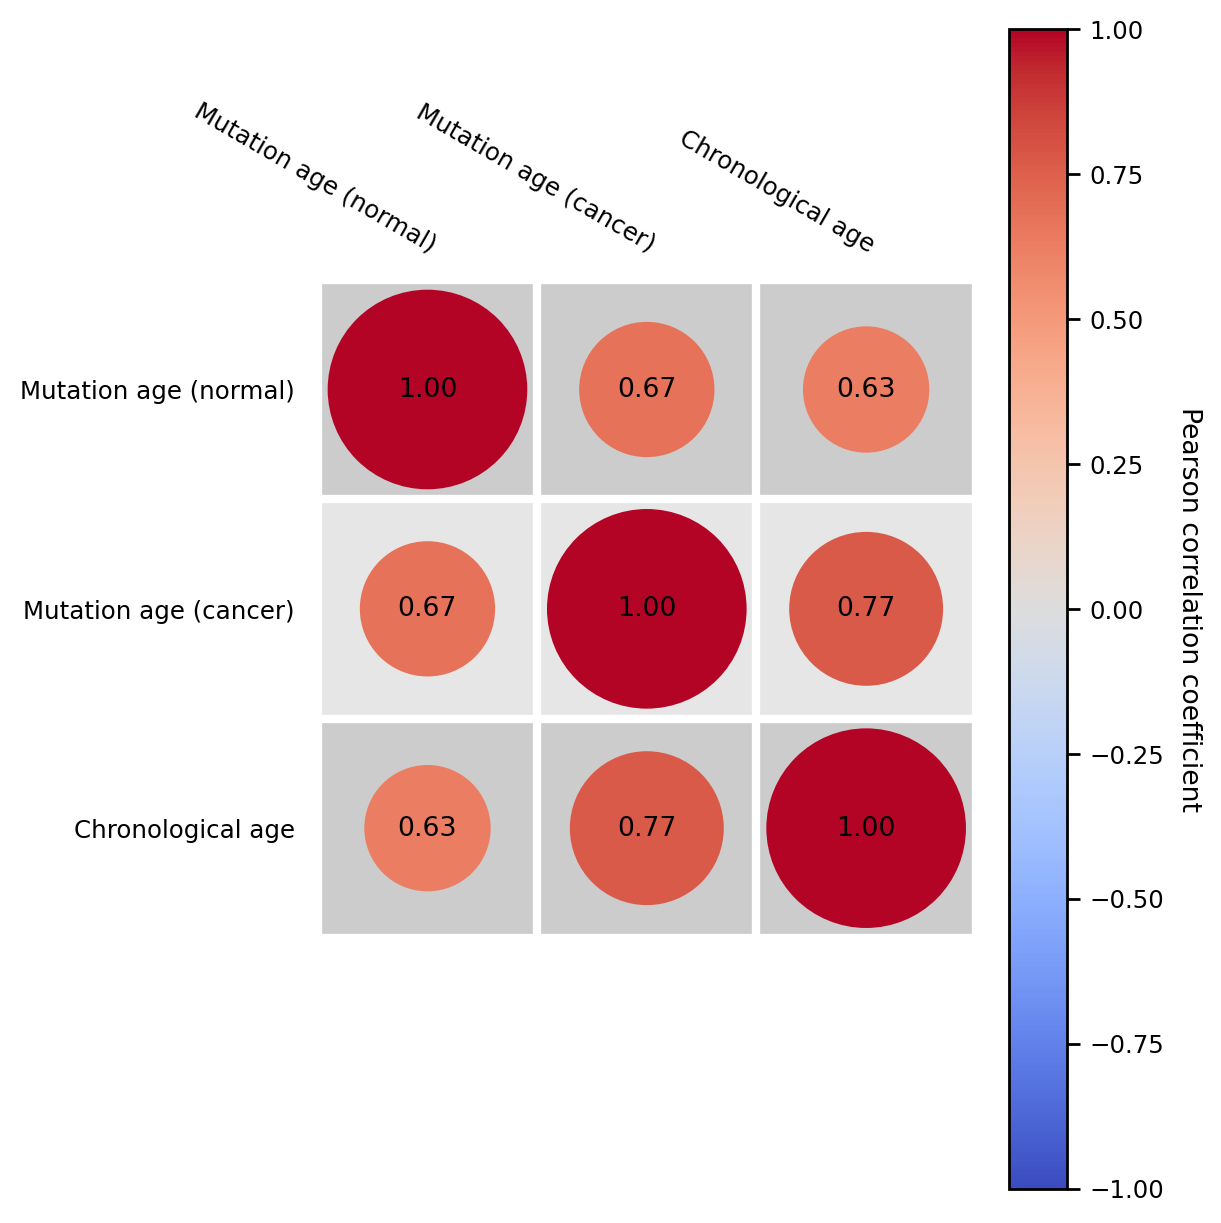

In [17]:
normal_predictions_df_to_merge = normal_predictions_df.copy(deep = True)
# add _cancer to index, so we get the cancer samples of these samples from combined_mut_predictions_df
normal_predictions_df_to_merge.index = normal_predictions_df_to_merge.index + '_cancer'
# merge
norm_and_cancer_mut_df = normal_predictions_df_to_merge.merge(combined_mut_predictions_df, left_index=True, right_index = True, how = 'left', suffixes = ('_normal', '_cancer'))
# remove _cancer from index
norm_and_cancer_mut_df.index = norm_and_cancer_mut_df.index.str[:-7]
# drop and rename
norm_and_cancer_mut_df.drop(columns = ['age_at_index_cancer', 'dataset_cancer', 'tissue_type', 'cv_num_normal','cv_num_cancer'], inplace = True)
norm_and_cancer_mut_df.rename(columns = {'age_at_index_normal':'age_at_index', 'dataset_normal':'dataset'}, inplace = True)
norm_and_cancer_mut_df.dropna(inplace = True)

data = norm_and_cancer_mut_df.query("dataset in @dsets_w_norm")[['mut_age_normal', 'mut_age_cancer', 'age_at_index']]
data.rename(columns = {'mut_age_normal':'Mutation age (normal)', 'mut_age_cancer':'Mutation age (cancer)', 'age_at_index': 'Chronological age'}, inplace = True)
kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
        'cmap': 'coolwarm',
    },
    'figure': {
        'figsize': (6, 6),
    },
    'cbar_kw':{
        "shrink": 0.1
    }
}

psynlig.plot_correlation_heatmap(data, bubble=True, annotate=True, **kwargs)

# print pairwise pearsonr results
for col in data.columns:
    for col2 in data.columns:
        if col != col2:
            print(f"{col} vs {col2}: {pearsonr(data[col], data[col2])}")
            
plt.savefig(os.path.join(fig_out_dir, "supp_fig4c.svg"), format = 'svg')

Methylation age (normal) vs Methylation age (cancer): PearsonRResult(statistic=0.8758941470617326, pvalue=1.9716135055880103e-07)
Methylation age (normal) vs Chronological age: PearsonRResult(statistic=0.9456012826287229, pvalue=1.0299817826861478e-10)
Methylation age (cancer) vs Methylation age (normal): PearsonRResult(statistic=0.8758941470617326, pvalue=1.9716135055880103e-07)
Methylation age (cancer) vs Chronological age: PearsonRResult(statistic=0.874508913788677, pvalue=2.178596936541125e-07)
Chronological age vs Methylation age (normal): PearsonRResult(statistic=0.9456012826287229, pvalue=1.0299817826861478e-10)
Chronological age vs Methylation age (cancer): PearsonRResult(statistic=0.874508913788677, pvalue=2.178596936541125e-07)


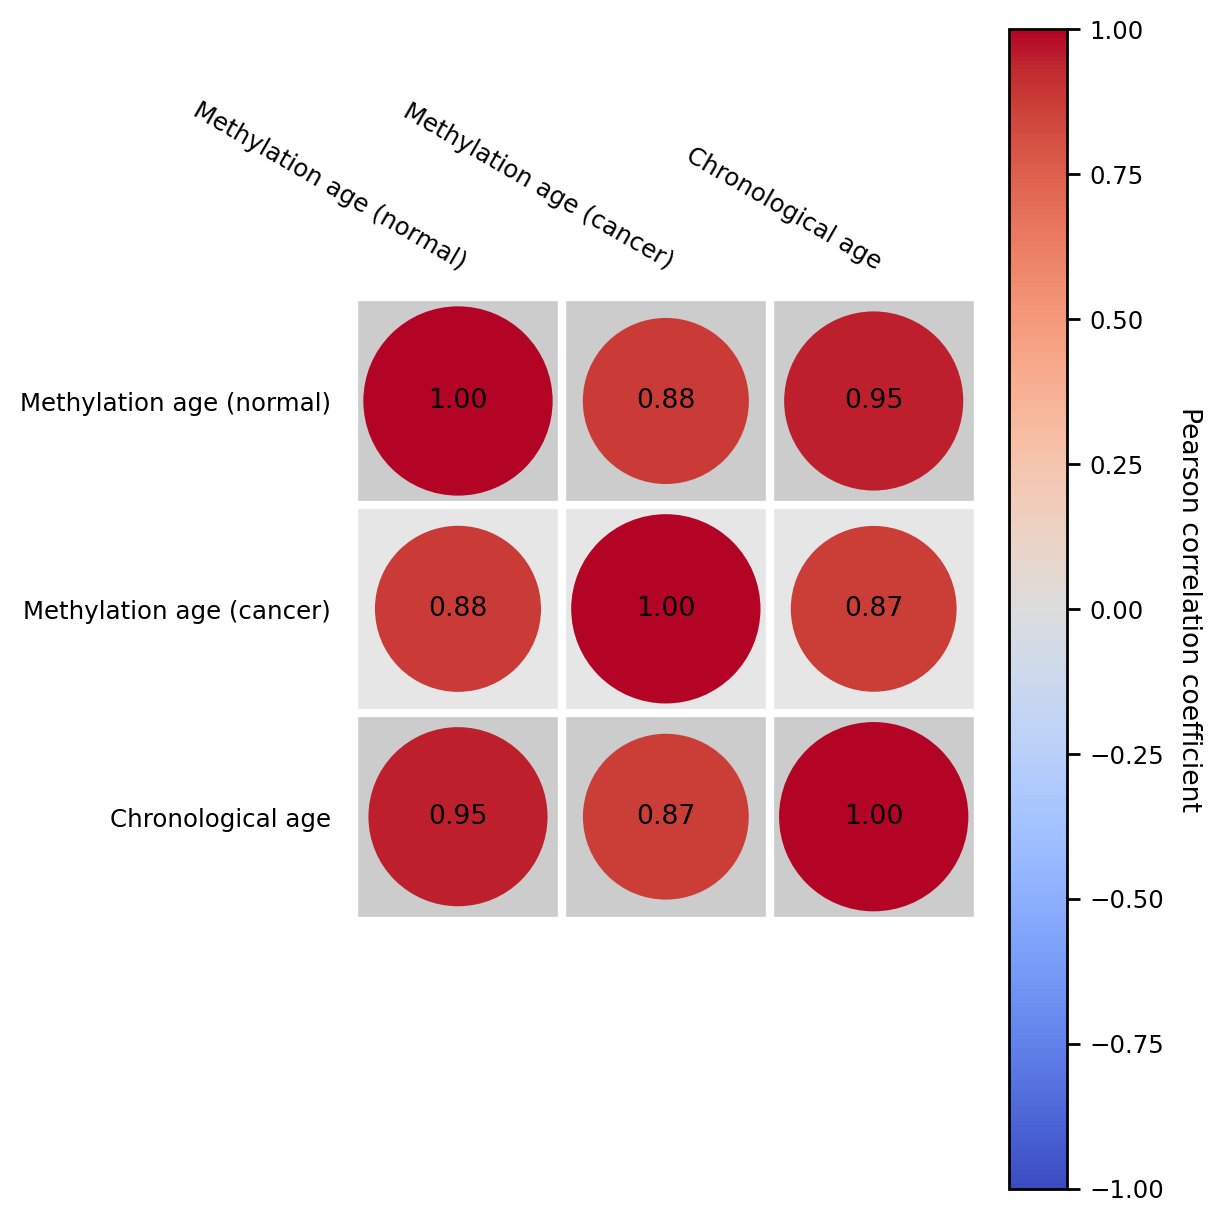

In [18]:
normal_predictions_df_to_merge = normal_predictions_df.copy(deep = True)
# add _cancer to index, so we get the cancer samples of these samples from combined_mut_predictions_df
normal_predictions_df_to_merge.index = normal_predictions_df_to_merge.index + '_cancer'
# merge
norm_and_cancer_methyl_df = normal_predictions_df_to_merge.merge(combined_predictions_df, left_index=True, right_index = True, how = 'left', suffixes = ('_normal', '_cancer'))
# remove _cancer from index
norm_and_cancer_methyl_df.index = norm_and_cancer_methyl_df.index.str[:-7]
# drop and rename
norm_and_cancer_methyl_df.drop(columns = ['age_at_index_cancer', 'dataset_cancer', 'tissue_type', 'cv_num_normal','cv_num_cancer','mut_age_normal', 'mut_age_cancer'], inplace = True)
norm_and_cancer_methyl_df.rename(columns = {'age_at_index_normal':'age_at_index', 'dataset_normal':'dataset'}, inplace = True)
norm_and_cancer_methyl_df.dropna(inplace = True)

data = norm_and_cancer_methyl_df.query("dataset in @dsets_w_norm")[['methyl_age_normal', 'methyl_age_cancer', 'age_at_index']]
data.rename(columns = {'methyl_age_normal':'Methylation age (normal)', 'methyl_age_cancer':'Methylation age (cancer)', 'age_at_index': 'Chronological age'}, inplace = True)
kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
        'cmap': 'coolwarm',
    },
    'figure': {
        'figsize': (6, 6),
    },
    'cbar_kw':{
        "shrink": 0.1
    }
}

psynlig.plot_correlation_heatmap(data, bubble=True, annotate=True, **kwargs)

# print pairwise pearsonr results
for col in data.columns:
    for col2 in data.columns:
        if col != col2:
            print(f"{col} vs {col2}: {pearsonr(data[col], data[col2])}")
            
# save to svg
plt.savefig(os.path.join(fig_out_dir, "supp_fig4d.svg"), format = 'svg')

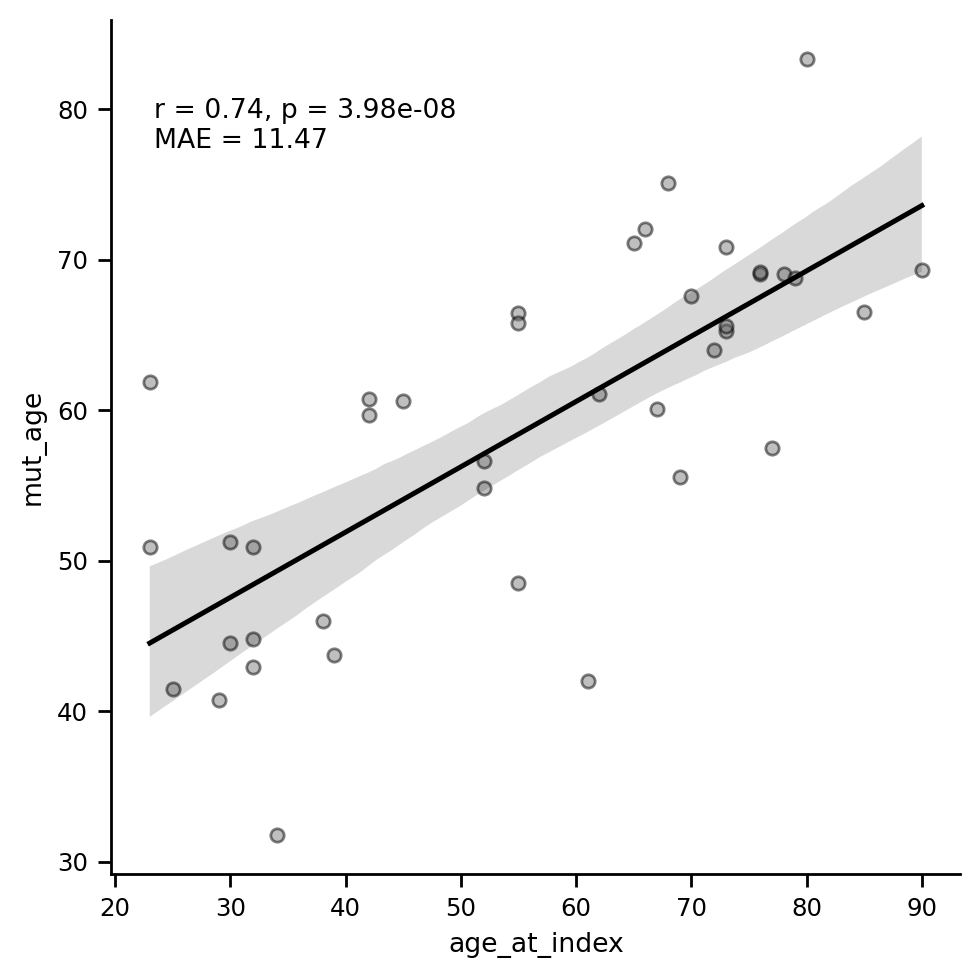

In [19]:
subset_tissues = normal_predictions_df.query("dataset in @dsets_w_norm")
sns.lmplot(
        data = subset_tissues, x = 'age_at_index', y = 'mut_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True, 'color': 'grey'},
        line_kws={'color':'black'}
        )
# add pearson corr and MAE to plot
r, p = pearsonr(subset_tissues['age_at_index'], subset_tissues['mut_age'])
mae = np.mean(np.abs(subset_tissues['age_at_index'] - subset_tissues['mut_age']))
# add to plot as text
plt.text(0.05, 0.85, f"r = {r:.2f}, p = {p:.2e}\nMAE = {mae:.2f}", transform=plt.gca().transAxes)


# set x and y ranges
plt.savefig(os.path.join(fig_out_dir, "supp_fig4e.svg"), format = 'svg')

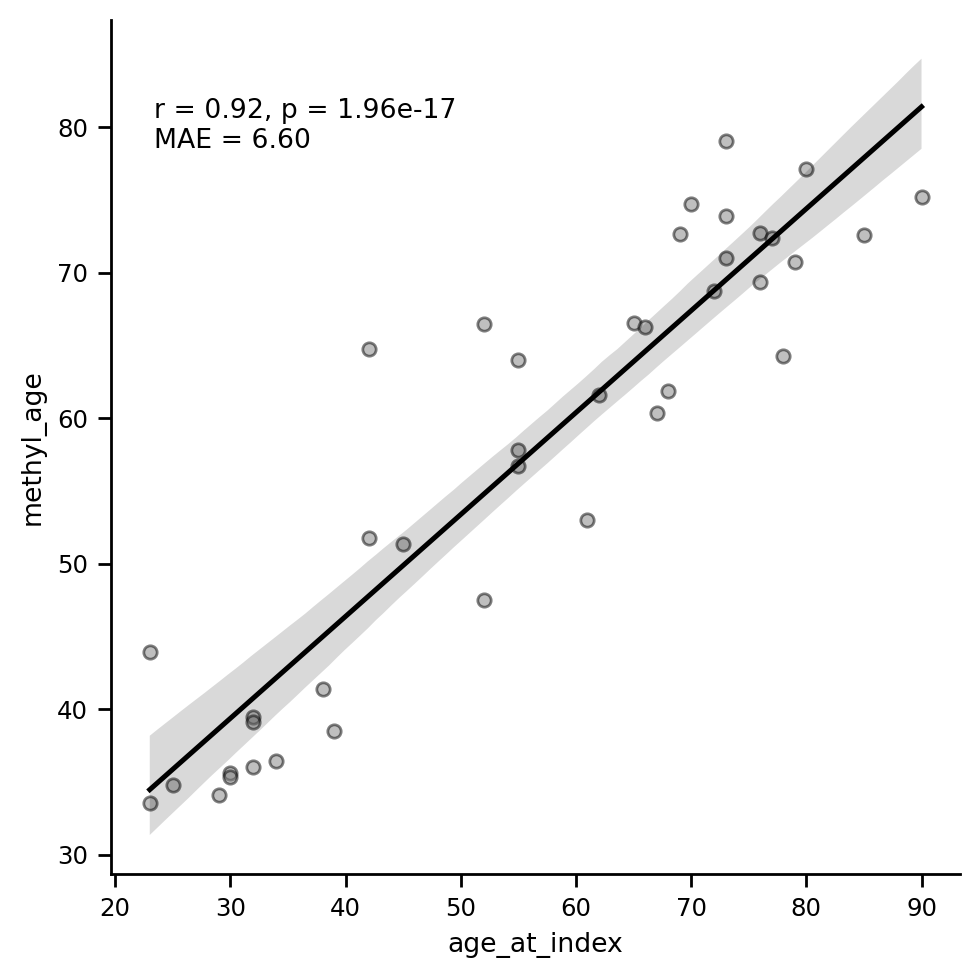

In [20]:
subset_tissues = normal_predictions_df.query("dataset in @dsets_w_norm")
sns.lmplot(
        data = subset_tissues, x = 'age_at_index', y = 'methyl_age', scatter_kws = {'alpha':0.5,'edgecolor':'black', 'rasterized':True, 'color': 'grey'},
        line_kws={'color':'black'}
        )
# add pearson corr and MAE to plot
r, p = pearsonr(subset_tissues['age_at_index'], subset_tissues['methyl_age'])
mae = np.mean(np.abs(subset_tissues['age_at_index'] - subset_tissues['methyl_age']))
# add to plot as text
plt.text(0.05, 0.85, f"r = {r:.2f}, p = {p:.2e}\nMAE = {mae:.2f}", transform=plt.gca().transAxes)
plt.savefig(os.path.join(fig_out_dir, "supp_fig4f.svg"), format = 'svg')


PearsonRResult(statistic=0.4792213282288243, pvalue=0.0017565543159531207)
SignificanceResult(statistic=0.5091932457786118, pvalue=0.0007921200279979275)


/tmp/ipykernel_336119/1740541375.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


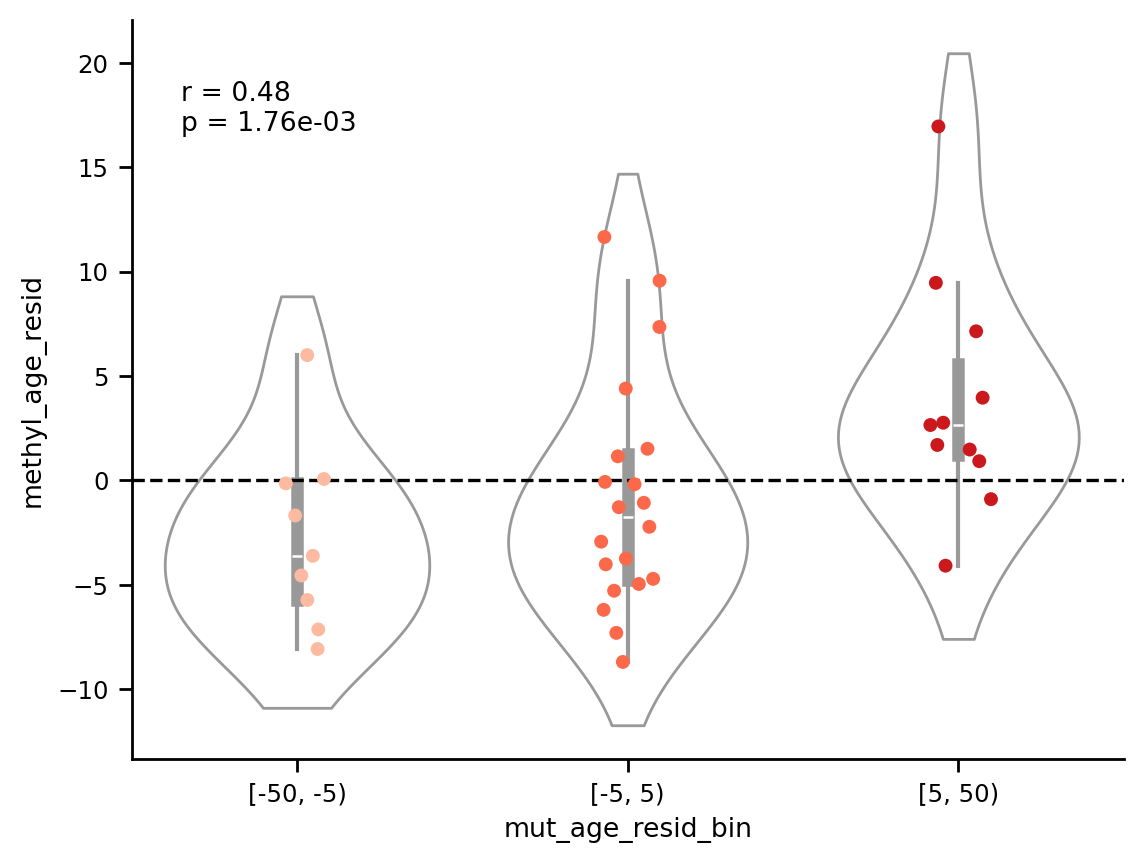

In [21]:
import statsmodels.formula.api as smf
mut_df = normal_predictions_df.query("dataset in @dsets_w_norm")

mut_and_methyl_df = normal_predictions_df.query("dataset in @dsets_w_norm")

mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_df).fit()
# using mutation samples w methyl
#mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
# calculate residuals
methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

# bin mutation age
mut_and_methyl_df['mut_age_resid_bin'] = mut_and_methyl_df['mut_age_resid'].transform(
                lambda x: pd.cut(x, bins =  [-50, -5,  5,50],
                                 right=False, duplicates = 'drop',)
                )
#mut_and_methyl_df['mut_age_resid_bin'] = pd.qcut(mut_and_methyl_df['mut_age_resid'], bins = [-30, -20, -10, 0, 10, 20, 30])
sns.stripplot(
            data = mut_and_methyl_df,
            x = 'mut_age_resid_bin', y = 'methyl_age_resid', palette='Reds',
            )
sns.violinplot(
            data = mut_and_methyl_df,
            x = 'mut_age_resid_bin', y = 'methyl_age_resid', color='white', cut = 1
            )
# draw dashed line as y = 0
plt.axhline(0, color='black', linestyle='--')
sns.despine()
print(pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
print(spearmanr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
r,p = pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
# add correlation anbd p to plot
plt.text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes)
plt.savefig(os.path.join(fig_out_dir, "supp_fig4g.svg"), format = 'svg')

# Supplemental Figure 6

In [22]:
# combined mut and methyl
combined_nowg_mut_model_dict, combined_nowg_mut_feat_dict, combined_nowg_mut_fmap_paths, combined_nowg_mut_predictions_df, combined_nowg_mut_parameters = read_in_trained_clock_perf("../data/models_and_predictions/mut/no_wg_features")
combined_methyl_model_dict, combined_methyl_feat_dict, combined_methyl_fmap_paths, combined_methyl_predictions_df, combined_methyl_parameters = read_in_trained_clock_perf("../data/models_and_predictions/methyl/all_features")
# combine predictions
combined_nowg_predictions_df = pd.concat([combined_methyl_predictions_df, combined_nowg_mut_predictions_df], axis = 1)
combined_nowg_predictions_df.dropna(inplace = True)
# drop duplicate columns
combined_nowg_predictions_df = combined_nowg_predictions_df.loc[:, ~combined_nowg_predictions_df.columns.duplicated()]
combined_nowg_mut_predictions_df['tissue_type'] = combined_nowg_mut_predictions_df.index.str.split('_').str[1]

combined_nowg_predictions_df['tissue_type'] = combined_nowg_predictions_df.index.str.split('_').str[1]

# read in normal mut and methyl
normal_nowg_mut_model_dict, normal_nowg_mut_feat_dict, normal_nowg_mut_fmap_paths, normal_nowg_mut_predictions_df, normal_nowg_mut_parameters = read_in_trained_clock_perf("../data/models_and_predictions/normal_tissue/mut/no_wg_features")
normal_methyl_model_dict, normal_methyl_feat_dict, normal_methyl_fmap_paths, normal_methyl_predictions_df, normal_methyl_parameters = read_in_trained_clock_perf("../data/models_and_predictions/normal_tissue/methyl/all_features")
# combine predictions
normal_nowg_predictions_df = pd.concat([normal_methyl_predictions_df, normal_nowg_mut_predictions_df], axis = 1)
normal_nowg_predictions_df.dropna(inplace = True)
# drop duplicate columns
normal_nowg_predictions_df = normal_nowg_predictions_df.loc[:, ~normal_nowg_predictions_df.columns.duplicated()]

/tmp/ipykernel_336119/285946196.py:19: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.barplot(
/tmp/ipykernel_336119/285946196.py:19: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
/tmp/ipykernel_336119/285946196.py:19: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


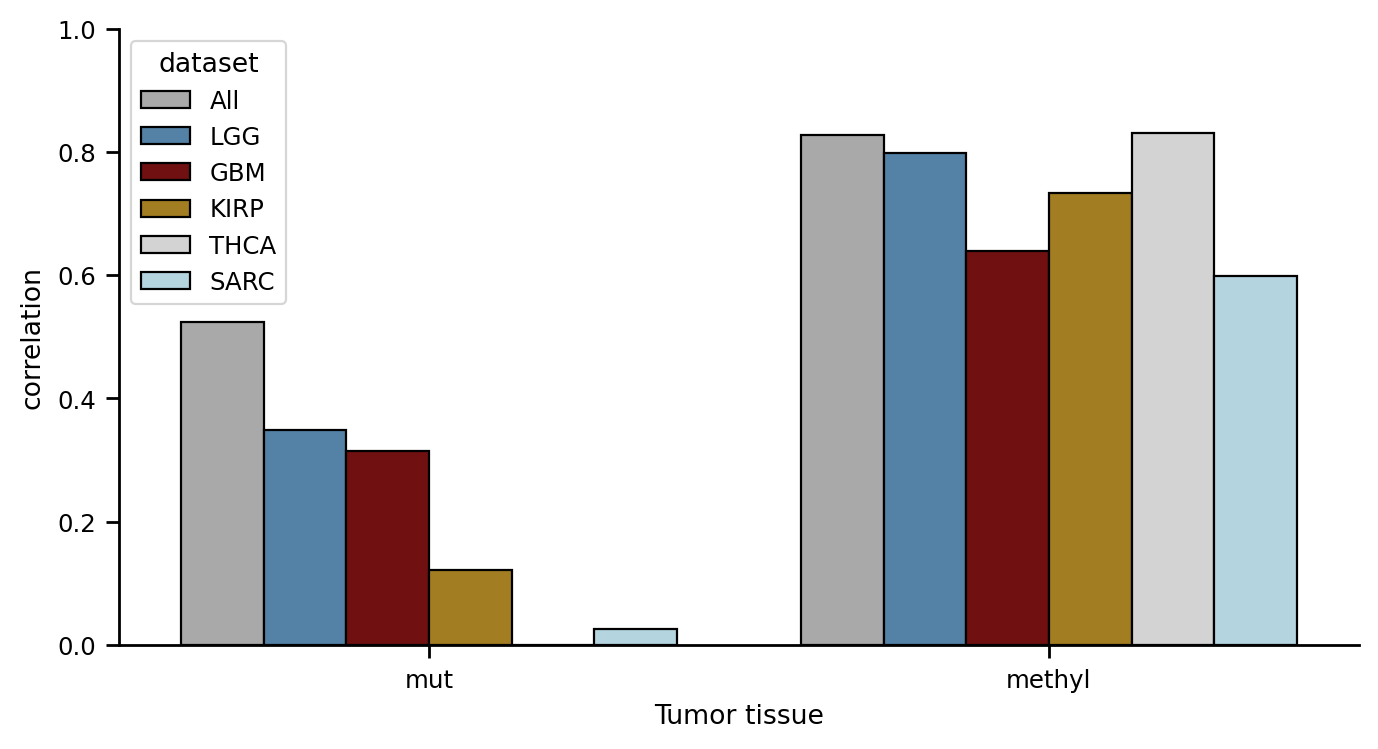

In [23]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

mut_and_methyl_df = combined_nowg_predictions_df.query("dataset in @dsets and tissue_type == 'cancer'")

# get the correlation values in each cv
mut_across_tissues_corr = mut_and_methyl_df[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
mut_across_tissues_corr['dataset'] = 'All'
methyl_across_tissues_corr = mut_and_methyl_df[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()
methyl_across_tissues_corr['dataset'] = 'All'
# get the correlation values in each dataset in each cv
mut_within_tissues_corr = mut_and_methyl_df.groupby(['dataset'])[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
methyl_within_tissues_corr = mut_and_methyl_df.groupby(['dataset'])[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()

# combine
all_corrs = pd.DataFrame({'dataset' : np.concatenate([mut_across_tissues_corr['dataset'], methyl_across_tissues_corr['dataset'], mut_within_tissues_corr['dataset'], methyl_within_tissues_corr['dataset']]), 'correlation': np.concatenate([mut_across_tissues_corr['mut_age'], methyl_across_tissues_corr['methyl_age'], mut_within_tissues_corr['mut_age'], methyl_within_tissues_corr['methyl_age']]), 'clock_type': np.concatenate([['mut']*len(mut_across_tissues_corr), ['methyl']*len(methyl_across_tissues_corr), ['mut']*len(mut_within_tissues_corr), ['methyl']*len(methyl_within_tissues_corr)])})

# set hue order based on mean with each clock_type group[]
hue_order = all_corrs.groupby(['dataset'])['correlation'].mean().sort_values(ascending=False).index
sns.barplot(
    all_corrs, hue = 'dataset', y = 'correlation', x = 'clock_type',
    palette = my_palette, hue_order = hue_order, errorbar = 'se',
    estimator=np.mean, 
    errwidth=1.5, capsize=0.05, 
    edgecolor = 'black', errcolor='black', ax = axes 
    )
sns.despine()
plt.ylim(0,1)
plt.xlabel("Tumor tissue")
plt.savefig(os.path.join(fig_out_dir, "supp_fig6a.svg"), format = 'svg')

/tmp/ipykernel_336119/1459456308.py:22: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
/tmp/ipykernel_336119/1459456308.py:22: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


KIRP
PearsonRResult(statistic=0.824368980187161, pvalue=0.04356060305863675)
PearsonRResult(statistic=0.6483025661338564, pvalue=0.163785708890841)
THCA
PearsonRResult(statistic=0.9543599210412042, pvalue=9.800492918852517e-09)
PearsonRResult(statistic=0.2142609092542084, pvalue=0.42554295206642995)
LIHC
PearsonRResult(statistic=0.8184606239598637, pvalue=0.02439396345303435)
PearsonRResult(statistic=0.25619206336003547, pvalue=0.5792062254870642)
COAD
PearsonRResult(statistic=0.5087166511569647, pvalue=0.11004243718546154)
PearsonRResult(statistic=0.0906788093667836, pvalue=0.7908935711236776)
all
PearsonRResult(statistic=0.923863947344558, pvalue=1.95554651823037e-17)
PearsonRResult(statistic=0.7286136167359698, pvalue=9.817248491658717e-08)


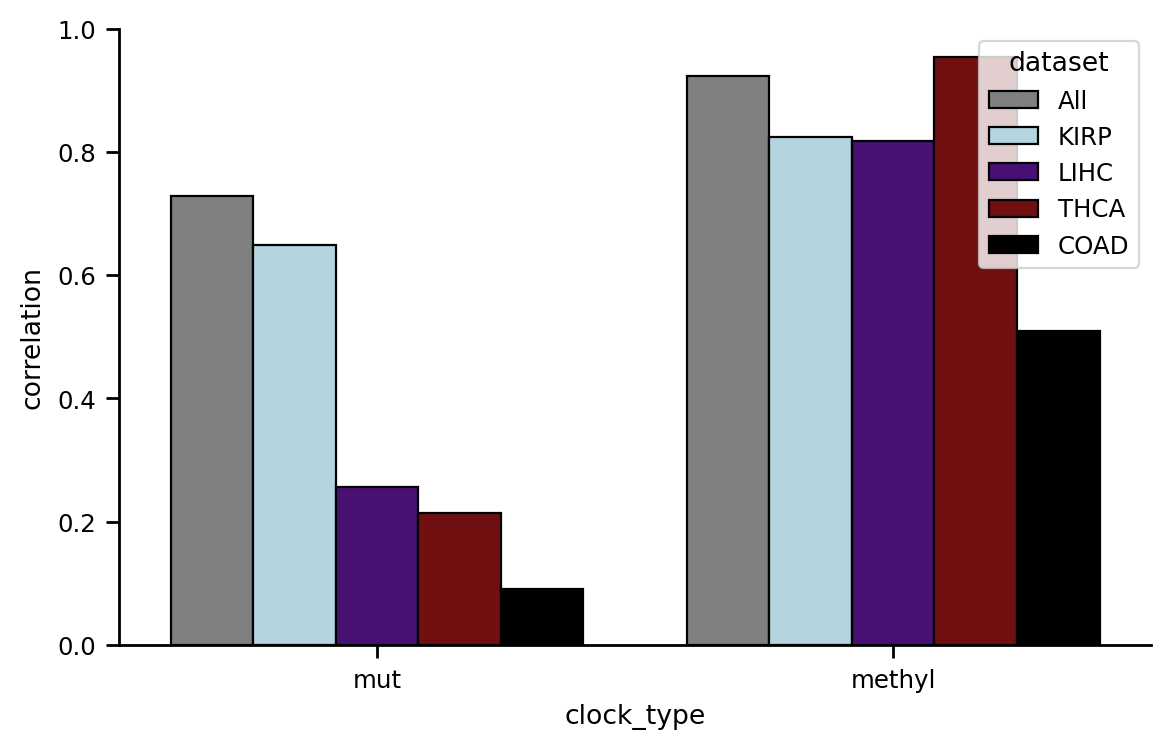

In [24]:
fig, axes = plt.subplots(1,1, figsize=(6.66,4))

mut_df = normal_nowg_predictions_df.query("dataset in @dsets_w_norm")
#mut_df = normal_nowg_mut_predictions_df.query("dataset in @norm_dsets_to_use")

mut_and_methyl_df = normal_nowg_predictions_df.query("dataset in @dsets_w_norm")

# get the correlation values in each cv
mut_across_tissues_corr = mut_df[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
mut_across_tissues_corr['dataset'] = 'All'
methyl_across_tissues_corr = mut_and_methyl_df[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()
methyl_across_tissues_corr['dataset'] = 'All'
# get the correlation values in each dataset in each cv
mut_within_tissues_corr = mut_df.groupby(['dataset'])[['age_at_index', 'mut_age']].corr().iloc[::2,-1].reset_index()
methyl_within_tissues_corr = mut_and_methyl_df.groupby(['dataset'])[['age_at_index', 'methyl_age']].corr().iloc[::2,-1].reset_index()

# combine
all_corrs = pd.DataFrame({'dataset' : np.concatenate([mut_across_tissues_corr['dataset'], methyl_across_tissues_corr['dataset'], mut_within_tissues_corr['dataset'], methyl_within_tissues_corr['dataset']]), 'correlation': np.concatenate([mut_across_tissues_corr['mut_age'], methyl_across_tissues_corr['methyl_age'], mut_within_tissues_corr['mut_age'], methyl_within_tissues_corr['methyl_age']]), 'clock_type': np.concatenate([['mut']*len(mut_across_tissues_corr), ['methyl']*len(methyl_across_tissues_corr), ['mut']*len(mut_within_tissues_corr), ['methyl']*len(methyl_within_tissues_corr)])})

# set hue order based on mean with each clock_type group[]
hue_order = all_corrs.query("clock_type == 'mut'").groupby(['dataset'])['correlation'].mean().sort_values(ascending=False).index
sns.barplot(
    all_corrs, hue = 'dataset', y = 'correlation', x = 'clock_type',
    hue_order = hue_order, errorbar = 'se',
    estimator=np.median, palette = ['grey', 'lightblue', 'indigo', 'maroon', 'black'],
    errwidth=1.5, capsize=0.05, 
    edgecolor = 'black', errcolor='black', ax=axes
    )
sns.despine()
plt.ylim(0,1)
plt.savefig(os.path.join(fig_out_dir, "supp_fig6b.svg"), format = 'svg')

#print pearsonr
for dset in dsets_w_norm:
    print(dset)
    print(pearsonr(mut_and_methyl_df.query("dataset == @dset")['age_at_index'], mut_and_methyl_df.query("dataset == @dset")['methyl_age']))
    print(pearsonr(mut_and_methyl_df.query("dataset == @dset")['age_at_index'], mut_and_methyl_df.query("dataset == @dset")['mut_age']))
print('all')
print(pearsonr(mut_and_methyl_df['age_at_index'], mut_and_methyl_df['methyl_age']))
print(pearsonr(mut_and_methyl_df['age_at_index'], mut_and_methyl_df['mut_age']))

/tmp/ipykernel_336119/669416923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
/tmp/ipykernel_336119/669416923.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid
/tmp/ipykernel_336119/669416923.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

PearsonRResult(statistic=0.5061634735548746, pvalue=6.658889275685309e-105)
SignificanceResult(statistic=0.48463598219733034, pvalue=4.560855038699159e-95)


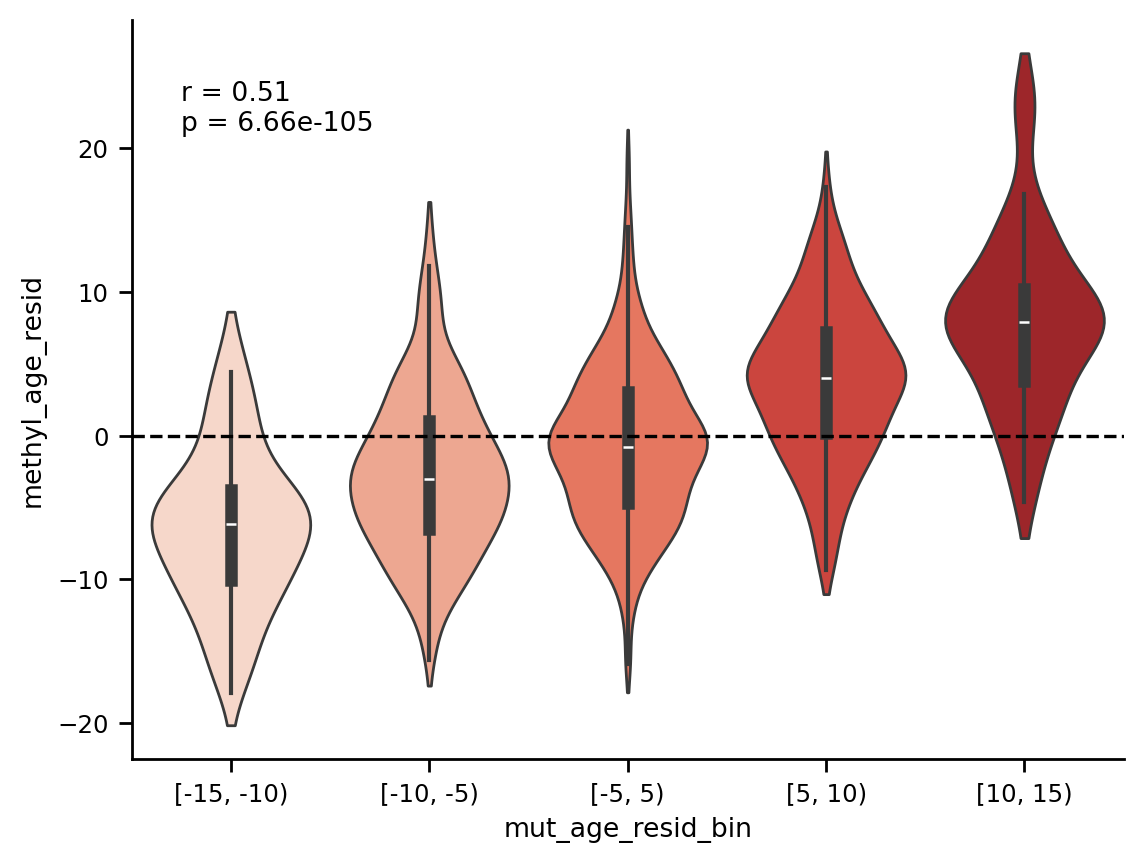

In [25]:
mut_and_methyl_df = combined_nowg_predictions_df.query("dataset in @dsets and tissue_type == 'cancer'")

mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_and_methyl_df).fit()
# using mutation samples w methyl
#mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
# calculate residuals
methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

# bin mutation age
mut_and_methyl_df['mut_age_resid_bin'] = mut_and_methyl_df['mut_age_resid'].transform(
                lambda x: pd.cut(x, bins =  [-15, -10, -5, 5,10,15],
                                 right=False, duplicates = 'drop',)
                )
#mut_and_methyl_df['mut_age_resid_bin'] = pd.qcut(mut_and_methyl_df['mut_age_resid'], bins = [-30, -20, -10, 0, 10, 20, 30])
sns.violinplot(
            data = mut_and_methyl_df,
            x = 'mut_age_resid_bin', y = 'methyl_age_resid', palette='Reds',
            cut = 1, 
            )
sns.despine()
print(pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
print(spearmanr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))

r,p = pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
# add correlation anbd p to plot
plt.text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes)
# add line at y=0
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig(os.path.join(fig_out_dir, "supp_fig6c.svg"), format = 'svg')

/tmp/ipykernel_336119/611310777.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


PearsonRResult(statistic=0.523237471457896, pvalue=0.0005315698646299901)
SignificanceResult(statistic=0.5035647279549719, pvalue=0.0009250333772829231)


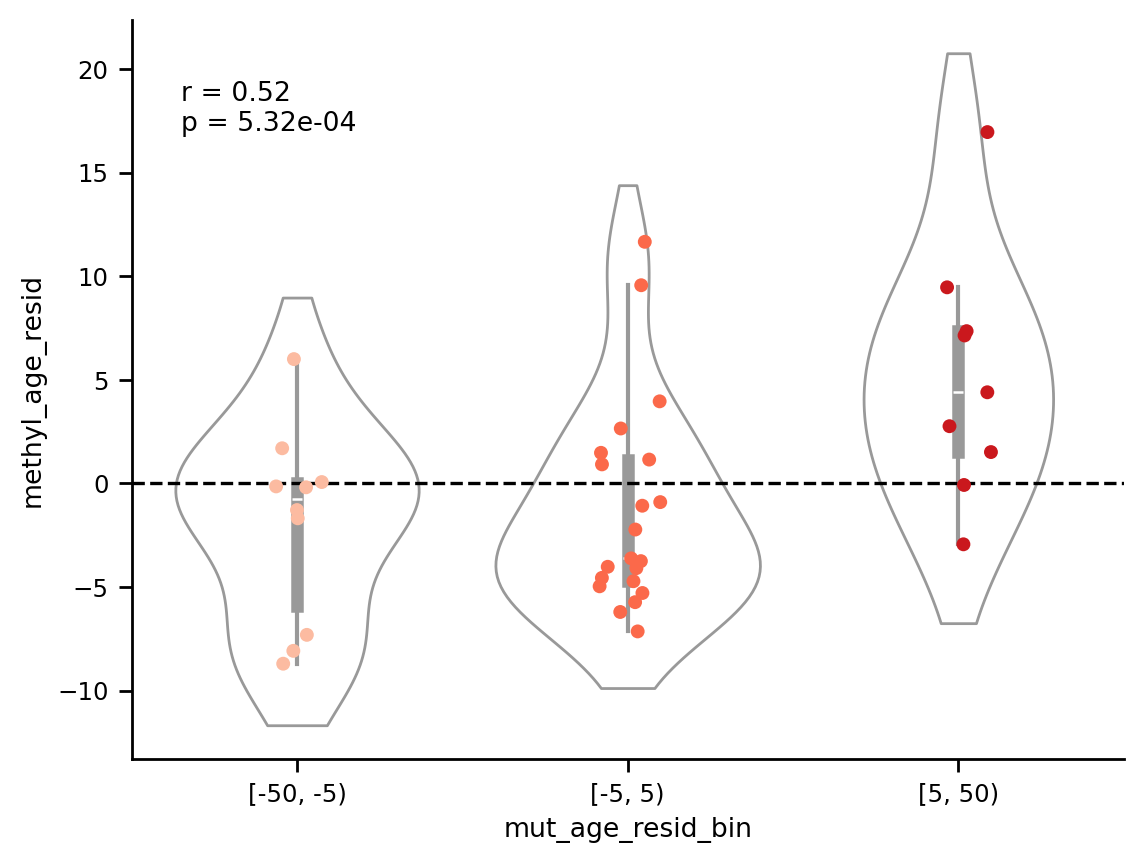

In [26]:
mut_df = normal_nowg_predictions_df.query("dataset in @dsets_w_norm")

mut_and_methyl_df = normal_nowg_predictions_df.query("dataset in @dsets_w_norm")

mut_regression = smf.ols("mut_age ~ age_at_index", data = mut_df).fit()
# using mutation samples w methyl
#mut_regression = smf.ols("mut_age ~ age_at_index*tissue_type", data = mut_and_methyl_df).fit()
mut_and_methyl_df['mut_age_resid'] = mut_regression.resid
# calculate residuals
methyl_regression = smf.ols("methyl_age ~ age_at_index", data = mut_and_methyl_df).fit()
mut_and_methyl_df['methyl_age_resid'] = methyl_regression.resid

# bin mutation age
mut_and_methyl_df['mut_age_resid_bin'] = mut_and_methyl_df['mut_age_resid'].transform(
                lambda x: pd.cut(x, bins =  [-50, -5,  5,50],
                                 right=False, duplicates = 'drop',)
                )
#mut_and_methyl_df['mut_age_resid_bin'] = pd.qcut(mut_and_methyl_df['mut_age_resid'], bins = [-30, -20, -10, 0, 10, 20, 30])
sns.stripplot(
            data = mut_and_methyl_df,
            x = 'mut_age_resid_bin', y = 'methyl_age_resid', palette='Reds',
            )
sns.violinplot(
            data = mut_and_methyl_df,
            x = 'mut_age_resid_bin', y = 'methyl_age_resid', color='white', cut = 1
            )
# draw dashed line as y = 0
plt.axhline(0, color='black', linestyle='--')
sns.despine()
print(pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
print(spearmanr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid']))
r,p = pearsonr(mut_and_methyl_df['mut_age_resid'], mut_and_methyl_df['methyl_age_resid'])
# add correlation anbd p to plot
plt.text(0.05, 0.85, f"r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes)
plt.savefig(os.path.join(fig_out_dir, "supp_fig6d.svg"), format = 'svg')